In [1]:
# Do analyst recommendations correlate with individual stock performance?
# This analysis focuses on relative analyst opinion of individual stocks.
# For the stocks analyzed (see stock_tickers below), higher returns
    # are not consistently seen with more bullish analyst opinions.
    # It seems like the relationship is positive, unrelated, and negative at about the same rates.
# A separate anaylsis in the future will look at if analyst-recommended stocks outperform the S&P in general
    # rather than focusing on performance of a single stock against its own recommendation baselines
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings("ignore")
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import sqlite3
from IPython.display import display
from sklearn.metrics import r2_score
import math
pd.set_option('display.max_columns',500)

In [2]:
stock_tickers = ['V','FB','AAPL','AMZN','NFLX','GOOGL','DIS','CBRL','HBI','XOM',\
                 'MO','CMCSA','T','BA','WFC','JPM','TSLA','JNJ','BIIB']
period = '5y'

In [3]:
def process_individual_stock(stock_ticker,period='5y',days_out=180,min_recommendations=5,color_method='Auto',\
                             qlow=0.15,qhigh=0.85,vmin=2.75,vmax=3.75,\
                             returns_method='Period',\
                             min_returns=5,split_size=50):
    # Prepare yfinance
    print('Results for: '+stock_ticker)
    stock=yf.Ticker(stock_ticker)
    
    # Get historical trading data
    try:
        history=stock.history(period=period)
    except:
        print('No history data for '+stock_ticker)
        return
    
    # Get recommendations
    try:
        recommendations=stock.recommendations.reset_index().sort_values(by=['Firm','Date'])
    except:
        print('No analyst recommendation data for '+stock_ticker)
        return
    recommendations['Next Recommendation']=recommendations.groupby('Firm')['Date'].shift(-1)
    recommendations[str(days_out)+' Days From']=recommendations['Date']+pd.Timedelta(days=days_out)
    recommendations['Good Until']=recommendations\
        [['Next Recommendation',str(days_out)+' Days From']]\
            .min(axis=1) # Define how long a recommendation lasts for - lowest of [days_out] or
                # [Until a new recommendation by that firm]

    # Process the recommendation values
    print('Recommendation values: '\
          +str(sorted(recommendations['To Grade'].dropna().unique()))) # Print out the unique recommendation grades
    assign_values = {'Buy':4, 'Equal-Weight':3, 'Hold':3, 'Market Perform':3, 'Neutral':3,
       'Outperform':4, 'Overweight':4, 'Peer Perform':3, 'Positive':4, 'Reduce':2,
       'Sector Perform':3, 'Sector Weight':3, 'Sell':1, 'Strong Buy':5, 'Underperform':1,
       'Underweight':1} # Create numeric representations of the recommendations
    recommendations['Assigned Value']=\
    recommendations['To Grade'].replace(assign_values) # Give the numeric representations a column
    
    # Store the dataframes in sqlite memory
    conn = sqlite3.connect(':memory:')
    history.to_sql('history', conn, index=True)
    recommendations.to_sql('recommendations', conn, index=False)
    
    # Get average analyst assigned scores by day using SQL
    qry = '''
    select h.open, h.high, h.low, h.close, h.volume, date(h.date) as Date, avg(r.'assigned value') as 'Average Assigned Value'
    from history h
    left join ( 
    select * from recommendations r 
    where r.firm in 
    (select firm from recommendations group by firm having count(date)>='''+str(int(min_recommendations))+''')
        -- Join recommendations, but only for firms with at least minimum recommendations recommendations
    ) r
    on date(h.date) between date(r.date) and date(r.'good until')
    group by h.open, h.high, h.low, h.close, h.volume, date(h.date)
        '''
    df = pd.read_sql_query(qry, conn).sort_values(by='Date')
    df['Date']=pd.to_datetime(df['Date'])

        
    # Make a plot with background color estimating recommendation sentiment for the periods
    # This considers the average recommendation overall
    fig,ax = plt.subplots()
    df.plot(figsize=(16,16),x='Date',y='Close',ax=ax)
    # # Originally used a list color map but change to a scalar map
    colormap=colors.LinearSegmentedColormap.from_list('custom',['Red','Yellow','Green'])
    # vmin, vmax = 2.5, 4.5 # Manual color definition
    if color_method == 'Auto':
        qlow = qlow
        qhigh = qhigh
        vmin = df['Average Assigned Value'].quantile(qlow) # Color definition using quantiles (low)
        vmax = df['Average Assigned Value'].quantile(qhigh) # Color definition using quantiles (high)
    elif color_method == 'Manual':
        vmin = vmin
        vmax = vmax
    else:
        print('Error: Please choose Auto or Manual to define your color scheme.')
        return
    normalize = colors.Normalize(vmin=vmin,vmax=vmax)
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    for idx, row in df.iterrows():
        ax.axvspan(row['Date'],row['Date']+pd.DateOffset(days=1),\
                   alpha=0.2,color=scalarmappaple.to_rgba(row['Average Assigned Value']))
    cbar=plt.colorbar(scalarmappaple,label='Average Analyst Recommendation',extend='both',fraction=0.046, pad=0.04)
    plt.show()
    
    # Get a correlation matrix of the current columns
    df['Returns']=(df['Close']-df['Close'].shift(1))/df['Close'].shift(1) # Day returns
    print('Correlation matrix for all data:')
    display(df.corr())
    
    if returns_method == 'Recommendation Moves':
        # Process the dataframe to get columns that can be grouped on the
                # analyst average recommendation to show how it affects returns
        df['Track Difference Up'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(1),0,1)
        df['Track Difference Down'] = np.where(df['Average Assigned Value']==df['Average Assigned Value'].shift(-1),0,1)
        df['Track Difference Unique'] = df['Track Difference Up'].cumsum()
        df['First Open'] = np.where(df['Track Difference Up']==1,df['Open'],None)
        df['Last Close'] = np.where(df['Track Difference Down']==1,df['Close'],None)

        # Get a grouped dataframe with returns data by average analyst recommendation
        returns_df = df.groupby(['Track Difference Unique','Average Assigned Value'])\
            .agg({'First Open':'min','Last Close':'max','Returns':'count'}).reset_index()
        returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
        returns_df['Daily Return']=100*\
            ((returns_df['Total Return Fraction']**(1/returns_df['Returns']))-1) # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)

        # Create a dataframe that has at least the minimum days
                    # (otherwise 1-day moves could yield high variance, potentially leading to false conclusions)
                    # Plot and correlate returns and ratings of that dataframe
        min_returns_df = returns_df[returns_df['Returns']>=min_returns]
        min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
        m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
        plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
        title = 'R2 Score: '+str(round(r2_score(min_returns_df['Daily Return'],min_returns_df['Average Assigned Value']*m+b),4))
        plt.title(title)
        plt.show()
        print('Correlation matrix for processed returns data:')
        display(min_returns_df.corr())
#         display(min_returns_df)
    
    elif returns_method == 'Period':
        # Split the stock into periods and find the return rate during that period as well as the average rating
        split_bins = math.ceil(df.shape[0]/split_size)
        df = pd.read_sql_query(qry, conn).sort_values(by='Date')
        df['Date']=pd.to_datetime(df['Date'])
        df['Period Group'] = pd.cut(df['Date'],split_bins)
        df['First Open'] = df.groupby('Period Group').head(1)['Open']
        df['Last Close'] = df.groupby('Period Group').tail(1)['Close']
#         display(df)
        
        # Get a grouped dataframe with returns data for that period to compare against average analyst recommendation
        returns_df = df.groupby(['Period Group'])\
        .agg({'First Open':'min','Last Close':'max','Date':'count','Average Assigned Value':'mean'}).reset_index()
        returns_df['Total Return Fraction']=returns_df['Last Close']/returns_df['First Open']
        returns_df['Daily Return']=100*\
            ((returns_df['Total Return Fraction']**(1/returns_df['Date']))-1) # Get the daily 
                            # return rate for the period by taking the n-th root of n-day
                                # cumulative stock movements and subtracting 1 (remember the compound interest equation)

        # Create a dataframe that has at least the minimum days. Get the return for each period bin.
                    # Then plot and correlate that dataframe
        min_returns_df = returns_df[returns_df['Date']\
                                    >=min(split_size-1,split_size*0.9)] # Each bin
                            # for plotting and correlation needs to be at least 90% the size of the split_size
        min_returns_df.plot(x='Average Assigned Value',y='Daily Return',kind='scatter',figsize=(12,12))
        m,b = np.polyfit(x=min_returns_df['Average Assigned Value'],y=min_returns_df['Daily Return'], deg=1)
        plt.plot(min_returns_df['Average Assigned Value'],min_returns_df['Average Assigned Value']*m+b)
        title = 'R2 Score: '+\
            str(round(r2_score(min_returns_df['Daily Return'],min_returns_df['Average Assigned Value']*m+b),4))
        plt.title(title)
        plt.show()
        print('Correlation matrix for processed returns data:')
        display(min_returns_df.corr())
#         display(min_returns_df)
    
    else:
        print('Error: Please choose Period or Recommendation Moves as your method of returns analysis.')
        return
    
    print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')

Results for: V
No analyst recommendation data for V
Results for: FB
Recommendation values: ['Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Mixed', 'Neutral', 'Outperform', 'Overweight', 'Positive', 'Reduce', 'Sector Perform', 'Sell', 'Strong Buy', 'Underperform']


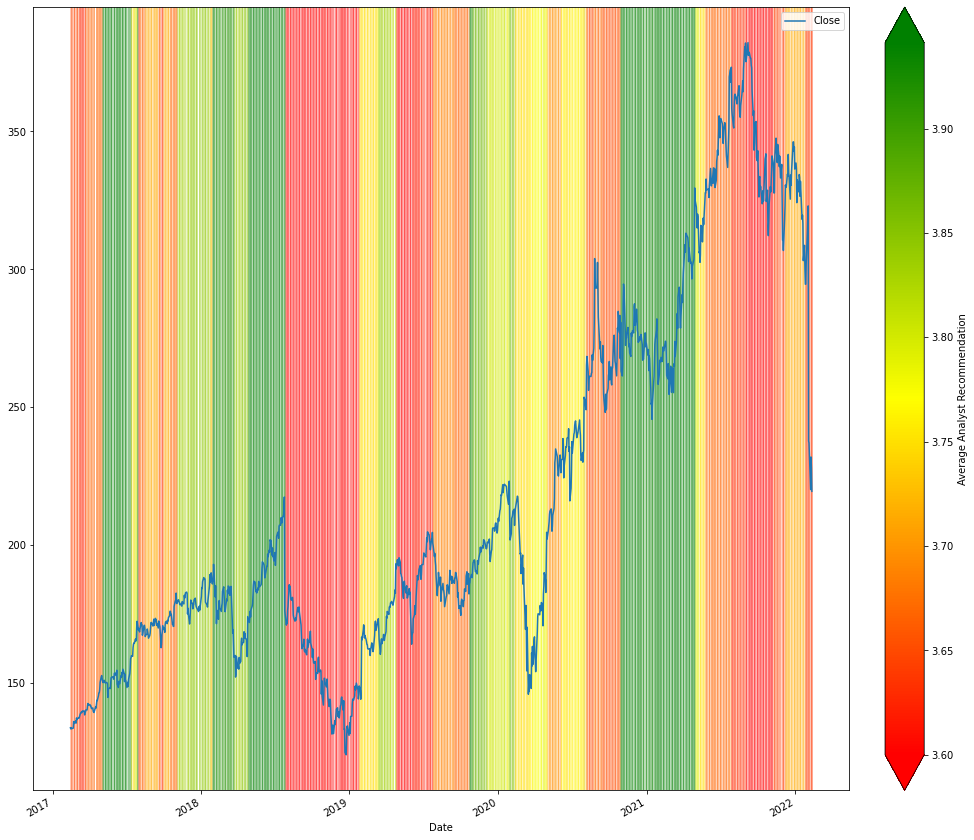

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999337,0.999241,0.998535,-0.063304,-0.010982,-0.010847
High,0.999337,1.000000,0.999082,0.999284,-0.052647,-0.011272,0.004893
Low,0.999241,0.999082,1.000000,0.999333,-0.077582,-0.009898,0.009535
Close,0.998535,0.999284,0.999333,1.000000,-0.066372,-0.009712,0.026853
Volume,-0.063304,-0.052647,-0.077582,-0.066372,1.000000,-0.020114,-0.197844
Average Assigned Value,-0.010982,-0.011272,-0.009898,-0.009712,-0.020114,1.000000,0.036613
Returns,-0.010847,0.004893,0.009535,0.026853,-0.197844,0.036613,1.000000


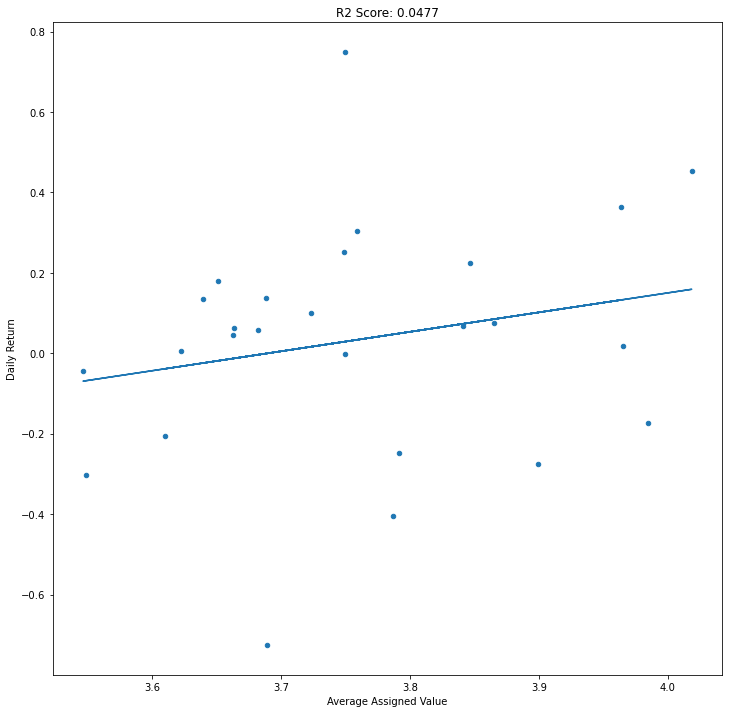

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.873963,0.081924,-0.062737,-0.345843,-0.358245
Last Close,0.873963,1.000000,0.112967,0.066198,0.133991,0.128974
Date,0.081924,0.112967,1.000000,-0.252812,0.084709,0.062339
Average Assigned Value,-0.062737,0.066198,-0.252812,1.000000,0.227481,0.218315
Total Return Fraction,-0.345843,0.133991,0.084709,0.227481,1.000000,0.992729
Daily Return,-0.358245,0.128974,0.062339,0.218315,0.992729,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: AAPL
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Long-Term Buy', 'Long-term Buy', 'Market Outperform', 'Market Perform', 'Negative', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


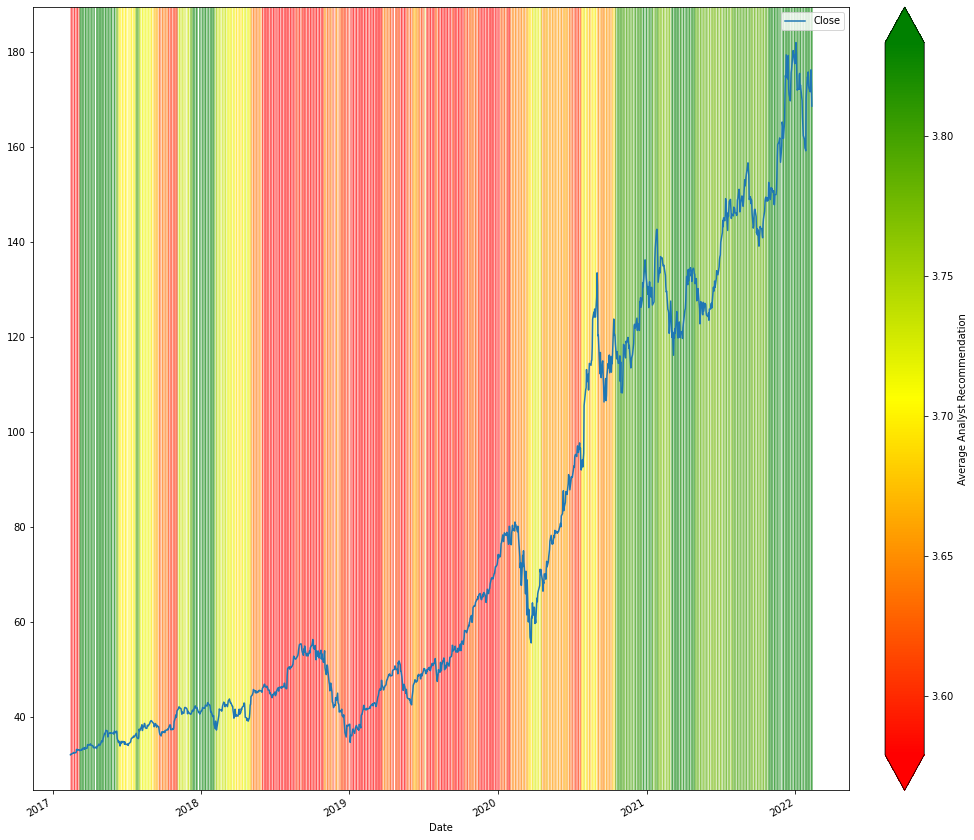

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999820,0.999744,0.999534,-0.155153,0.566191,0.005967
High,0.999820,1.000000,0.999689,0.999759,-0.148258,0.566060,0.013547
Low,0.999744,0.999689,1.000000,0.999762,-0.164227,0.566874,0.015383
Close,0.999534,0.999759,0.999762,1.000000,-0.156751,0.566245,0.026337
Volume,-0.155153,-0.148258,-0.164227,-0.156751,1.000000,-0.156662,-0.083293
Average Assigned Value,0.566191,0.566060,0.566874,0.566245,-0.156662,1.000000,-0.003492
Returns,0.005967,0.013547,0.015383,0.026337,-0.083293,-0.003492,1.000000


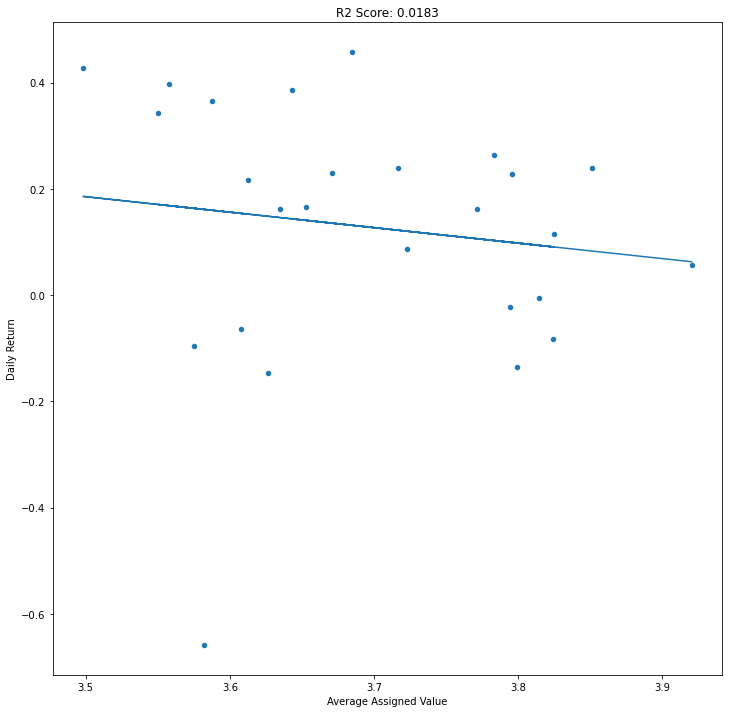

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.984709,0.046688,0.626419,-0.051579,-0.030793
Last Close,0.984709,1.000000,0.123427,0.599314,0.108984,0.127389
Date,0.046688,0.123427,1.000000,-0.036851,0.464011,0.491351
Average Assigned Value,0.626419,0.599314,-0.036851,1.000000,-0.183041,-0.135215
Total Return Fraction,-0.051579,0.108984,0.464011,-0.183041,1.000000,0.994459
Daily Return,-0.030793,0.127389,0.491351,-0.135215,0.994459,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: AMZN
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Fair Value', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Weight', 'Sell', 'Strong Buy']


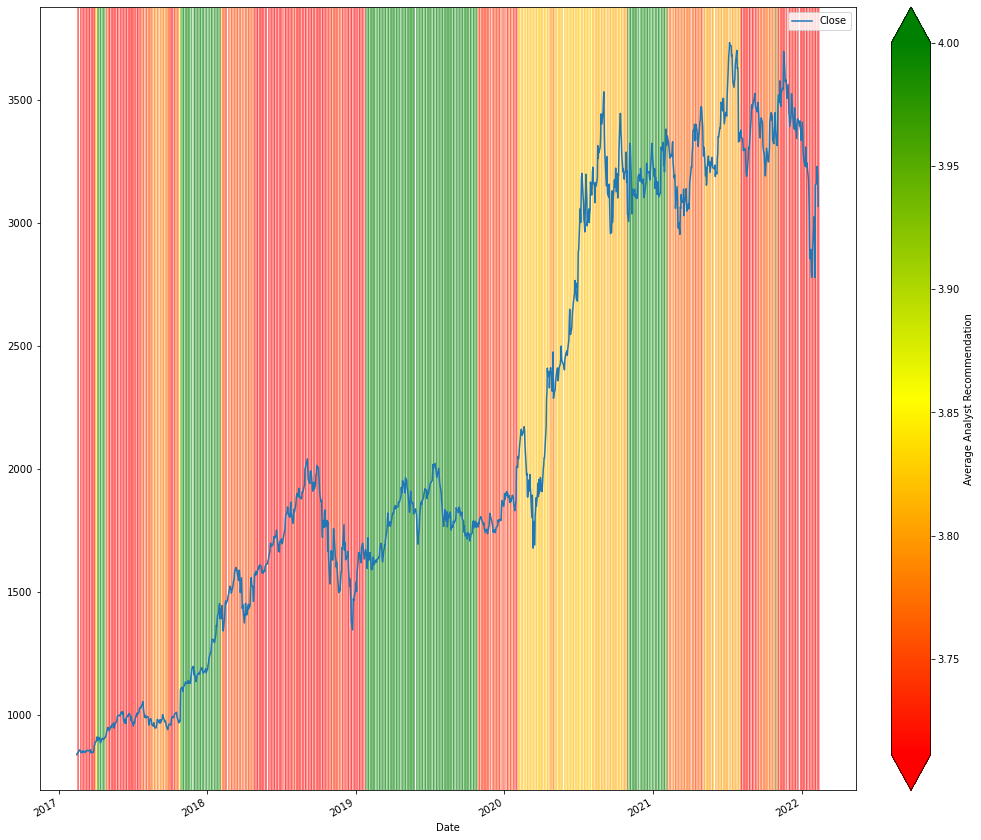

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999657,0.999545,0.999143,-0.079785,0.074257,-0.031358
High,0.999657,1.000000,0.999445,0.999588,-0.070260,0.073354,-0.018274
Low,0.999545,0.999445,1.000000,0.999597,-0.092892,0.075781,-0.016079
Close,0.999143,0.999588,0.999597,1.000000,-0.081690,0.075058,-0.001175
Volume,-0.079785,-0.070260,-0.092892,-0.081690,1.000000,-0.010113,-0.020737
Average Assigned Value,0.074257,0.073354,0.075781,0.075058,-0.010113,1.000000,0.010013
Returns,-0.031358,-0.018274,-0.016079,-0.001175,-0.020737,0.010013,1.000000


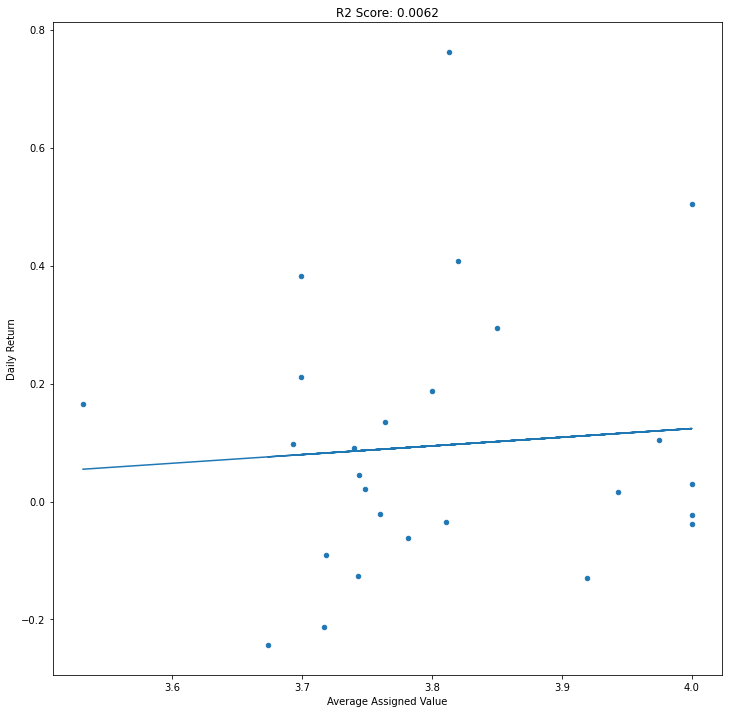

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.964529,0.058879,0.053118,-0.347968,-0.367270
Last Close,0.964529,1.000000,0.080060,0.079442,-0.101999,-0.121235
Date,0.058879,0.080060,1.000000,-0.222896,0.044144,0.032257
Average Assigned Value,0.053118,0.079442,-0.222896,1.000000,0.070689,0.078938
Total Return Fraction,-0.347968,-0.101999,0.044144,0.070689,1.000000,0.996601
Daily Return,-0.367270,-0.121235,0.032257,0.078938,0.996601,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: NFLX
Recommendation values: ['', 'Average', 'Below Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Fair Value', 'Hold', 'In-Line', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Perform', 'Sector Weight', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


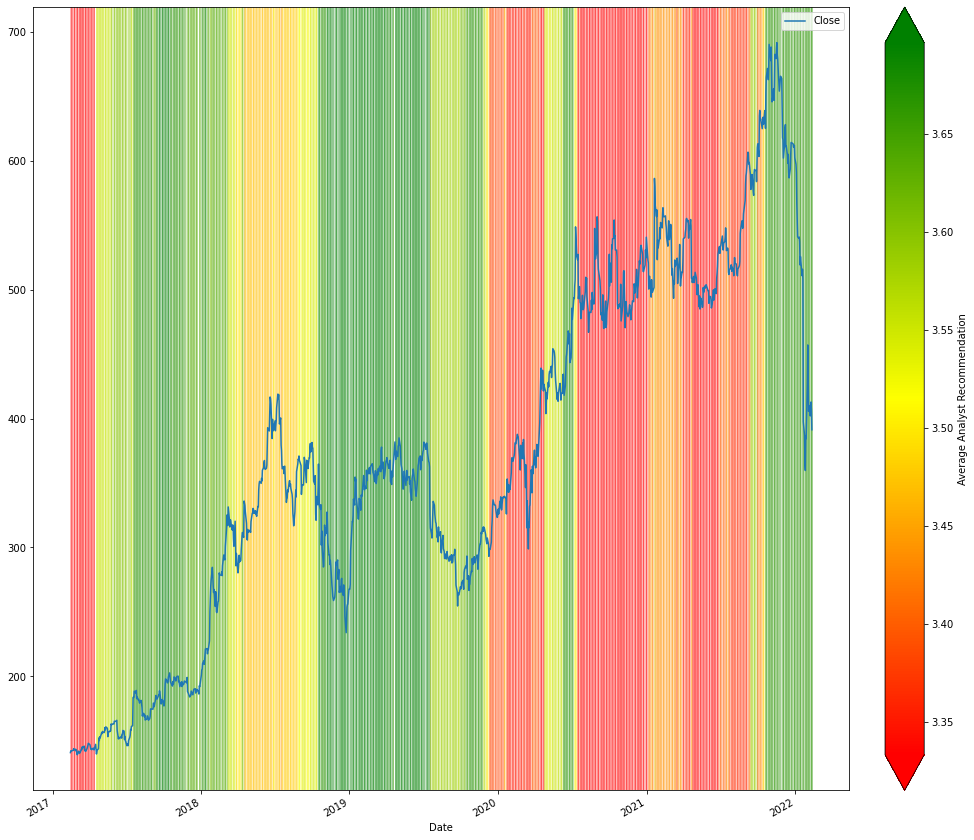

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999275,0.999212,0.998362,-0.223660,-0.284034,-0.037841
High,0.999275,1.000000,0.999023,0.999250,-0.211094,-0.284700,-0.017898
Low,0.999212,0.999023,1.000000,0.999236,-0.236573,-0.286128,-0.015579
Close,0.998362,0.999250,0.999236,1.000000,-0.221253,-0.285769,0.005830
Volume,-0.223660,-0.211094,-0.236573,-0.221253,1.000000,0.210423,0.001646
Average Assigned Value,-0.284034,-0.284700,-0.286128,-0.285769,0.210423,1.000000,0.003474
Returns,-0.037841,-0.017898,-0.015579,0.005830,0.001646,0.003474,1.000000


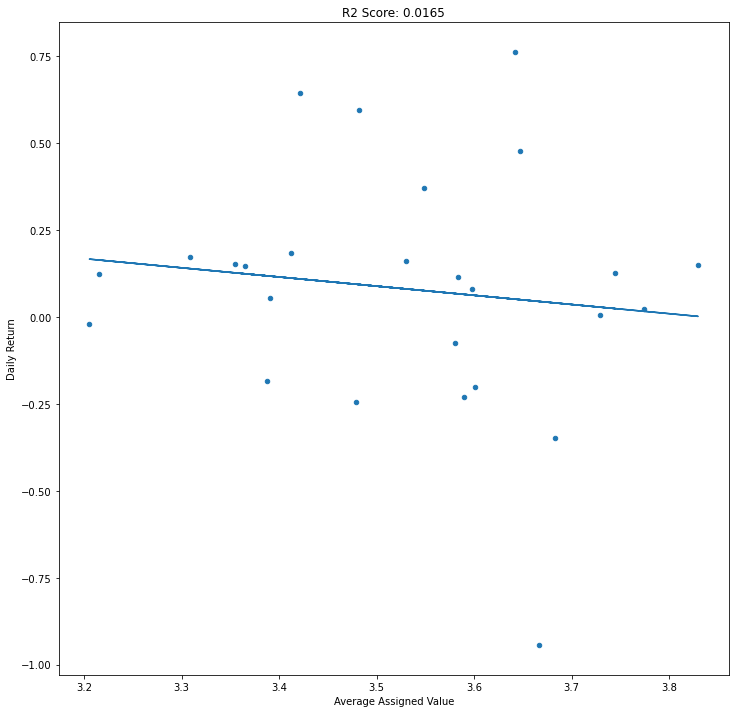

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.891470,0.104541,-0.281527,-0.440564,-0.448165
Last Close,0.891470,1.000000,-0.004684,-0.397010,-0.024312,-0.015250
Date,0.104541,-0.004684,1.000000,-0.171575,-0.292900,-0.305133
Average Assigned Value,-0.281527,-0.397010,-0.171575,1.000000,-0.109904,-0.128597
Total Return Fraction,-0.440564,-0.024312,-0.292900,-0.109904,1.000000,0.991250
Daily Return,-0.448165,-0.015250,-0.305133,-0.128597,0.991250,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: GOOGL
Recommendation values: ['', 'Buy', 'Equal-weight', 'Hold', 'Long-Term Buy', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Positive', 'Sell', 'Strong Buy', 'Underperform']


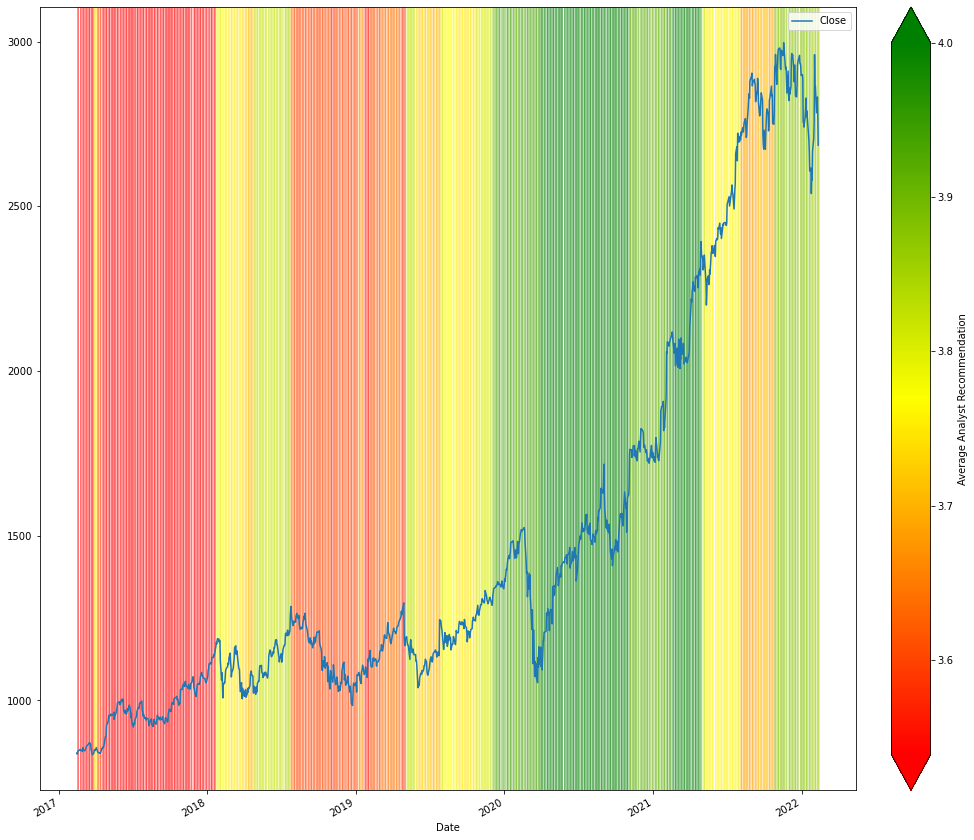

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999738,0.999691,0.999412,-0.110305,0.399456,0.005723
High,0.999738,1.000000,0.999606,0.999691,-0.103212,0.403611,0.015737
Low,0.999691,0.999606,1.000000,0.999734,-0.120731,0.397121,0.017839
Close,0.999412,0.999691,0.999734,1.000000,-0.113435,0.400441,0.029252
Volume,-0.110305,-0.103212,-0.120731,-0.113435,1.000000,0.108275,-0.049349
Average Assigned Value,0.399456,0.403611,0.397121,0.400441,0.108275,1.000000,0.025870
Returns,0.005723,0.015737,0.017839,0.029252,-0.049349,0.025870,1.000000


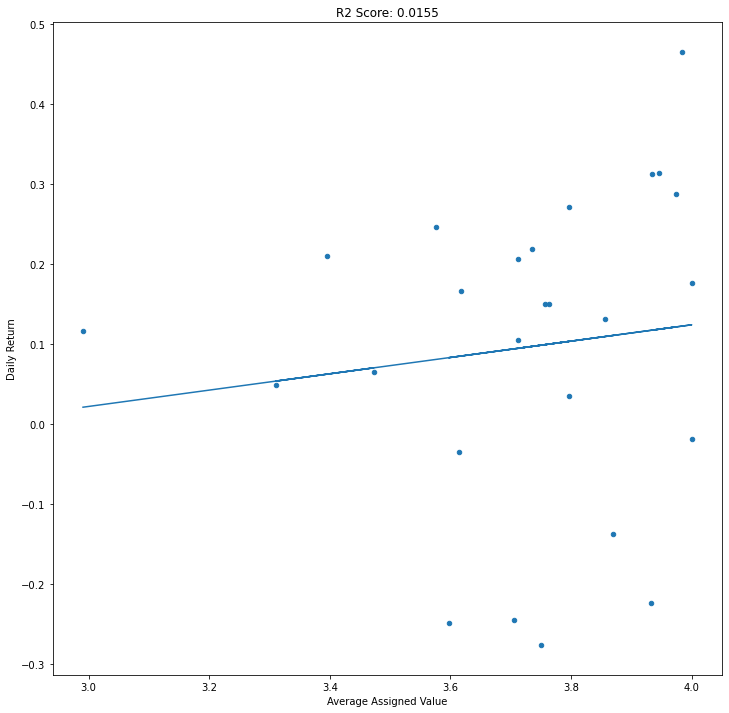

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.973908,0.091420,0.426619,-0.045690,-0.038993
Last Close,0.973908,1.000000,0.078965,0.453060,0.170729,0.177098
Date,0.091420,0.078965,1.000000,-0.074723,0.006097,-0.013374
Average Assigned Value,0.426619,0.453060,-0.074723,1.000000,0.143188,0.124605
Total Return Fraction,-0.045690,0.170729,0.006097,0.143188,1.000000,0.998159
Daily Return,-0.038993,0.177098,-0.013374,0.124605,0.998159,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: DIS
Recommendation values: ['', 'Average', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'In-Line', 'Long-Term Buy', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sell', 'Top Pick', 'Underperform', 'Underweight']


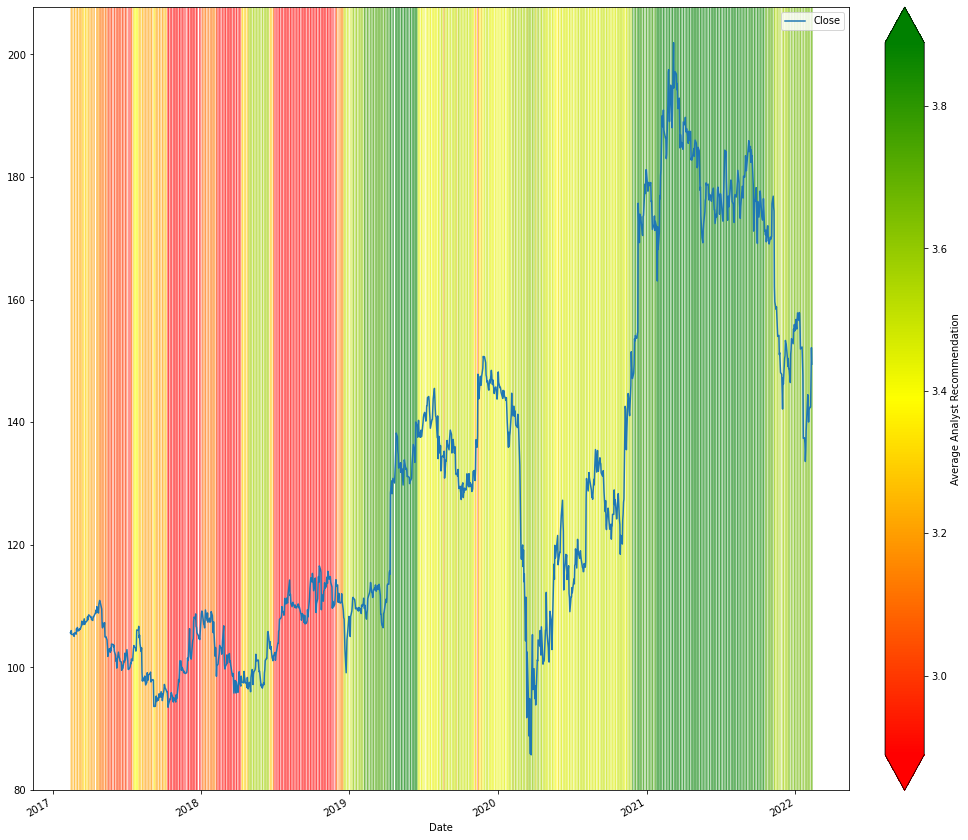

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999075,0.998994,0.998194,0.034964,0.637538,-0.006799
High,0.999075,1.000000,0.998470,0.999123,0.053636,0.640406,0.016807
Low,0.998994,0.998470,1.000000,0.998941,0.014483,0.634150,0.012493
Close,0.998194,0.999123,0.998941,1.000000,0.036522,0.638748,0.037127
Volume,0.034964,0.053636,0.014483,0.036522,1.000000,0.199178,0.105675
Average Assigned Value,0.637538,0.640406,0.634150,0.638748,0.199178,1.000000,0.017789
Returns,-0.006799,0.016807,0.012493,0.037127,0.105675,0.017789,1.000000


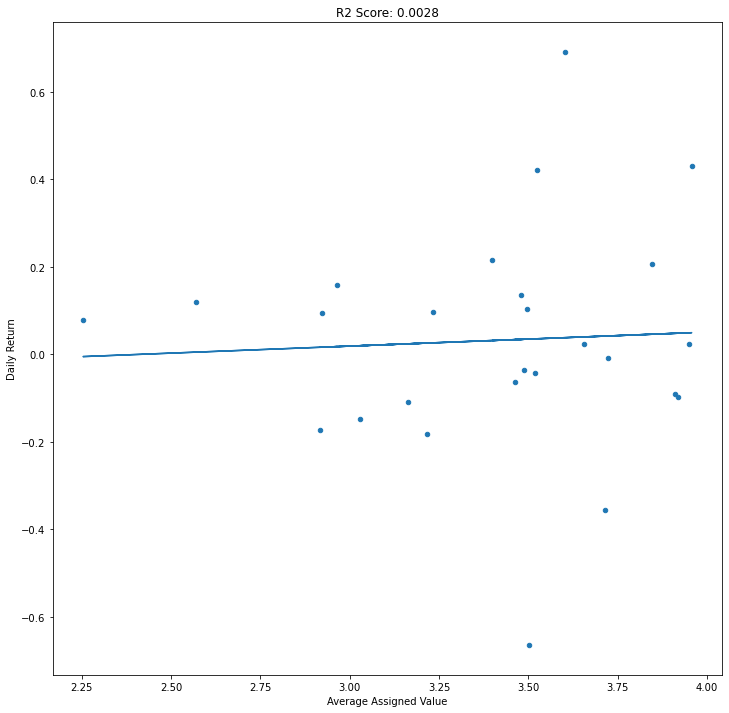

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.843522,-0.083687,0.632439,-0.290143,-0.295616
Last Close,0.843522,1.000000,-0.108438,0.663251,0.262153,0.257422
Date,-0.083687,-0.108438,1.000000,-0.136640,0.007494,-0.002116
Average Assigned Value,0.632439,0.663251,-0.136640,1.000000,0.070954,0.053098
Total Return Fraction,-0.290143,0.262153,0.007494,0.070954,1.000000,0.992701
Daily Return,-0.295616,0.257422,-0.002116,0.053098,0.992701,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: CBRL
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Underperform', 'Underweight']


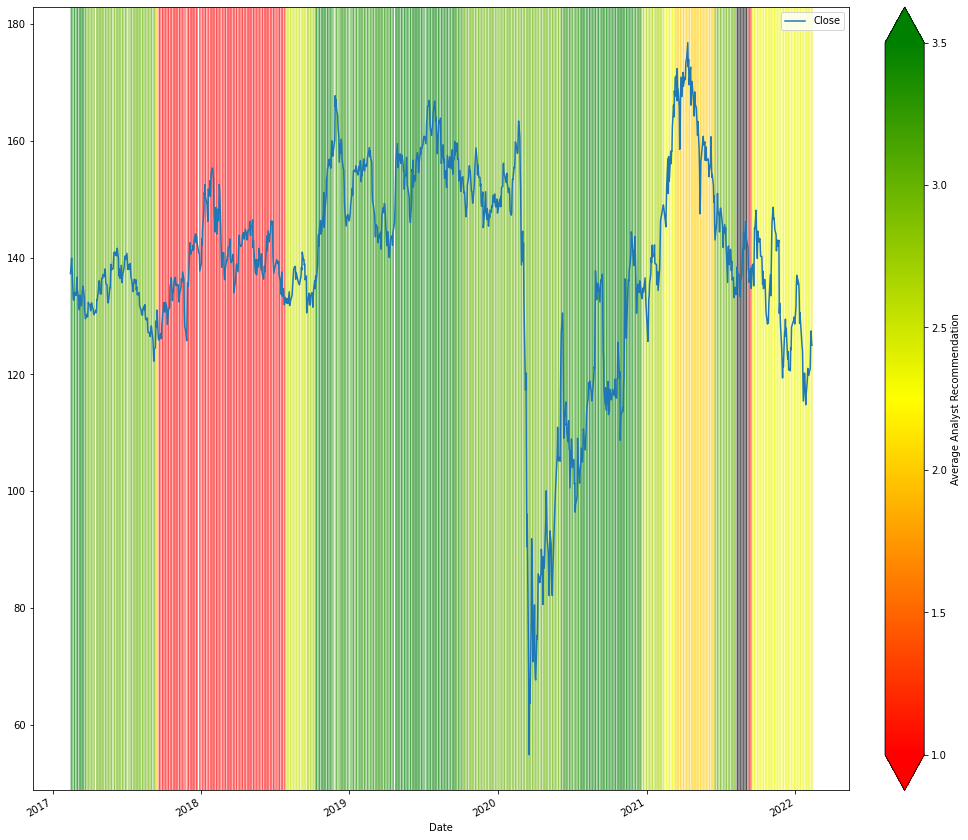

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.995377,0.995110,0.990658,-0.342709,-0.057293,-0.057916
High,0.995377,1.000000,0.993816,0.994970,-0.311744,-0.055568,-0.001804
Low,0.995110,0.993816,1.000000,0.996271,-0.375127,-0.060431,0.001980
Close,0.990658,0.994970,0.996271,1.000000,-0.351658,-0.057156,0.053262
Volume,-0.342709,-0.311744,-0.375127,-0.351658,1.000000,0.166295,-0.040677
Average Assigned Value,-0.057293,-0.055568,-0.060431,-0.057156,0.166295,1.000000,0.012045
Returns,-0.057916,-0.001804,0.001980,0.053262,-0.040677,0.012045,1.000000


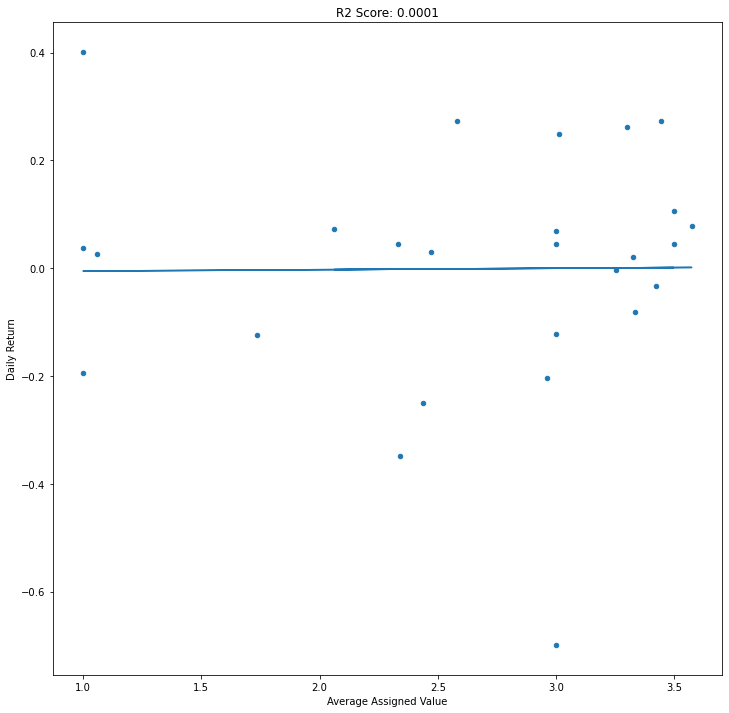

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.668627,-0.248373,-0.091651,-0.493992,-0.471603
Last Close,0.668627,1.000000,-0.329172,-0.088104,0.313494,0.337853
Date,-0.248373,-0.329172,1.000000,0.025698,-0.088986,-0.080934
Average Assigned Value,-0.091651,-0.088104,0.025698,1.000000,0.017045,0.009947
Total Return Fraction,-0.493992,0.313494,-0.088986,0.017045,1.000000,0.996414
Daily Return,-0.471603,0.337853,-0.080934,0.009947,0.996414,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: HBI
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


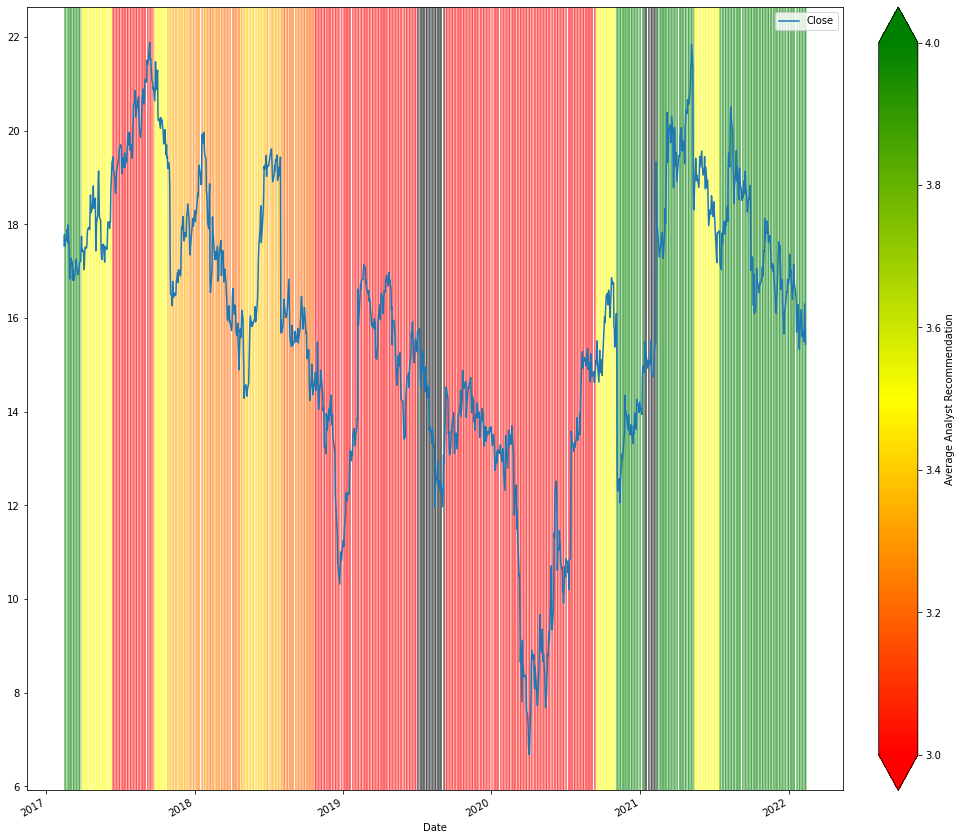

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.997185,0.996894,0.993863,-0.290021,0.631337,-0.031221
High,0.997185,1.000000,0.996302,0.996905,-0.267596,0.634006,0.010486
Low,0.996894,0.996302,1.000000,0.997392,-0.312741,0.630691,0.014591
Close,0.993863,0.996905,0.997392,1.000000,-0.292659,0.630894,0.056957
Volume,-0.290021,-0.267596,-0.312741,-0.292659,1.000000,-0.243705,-0.042333
Average Assigned Value,0.631337,0.634006,0.630691,0.630894,-0.243705,1.000000,-0.013881
Returns,-0.031221,0.010486,0.014591,0.056957,-0.042333,-0.013881,1.000000


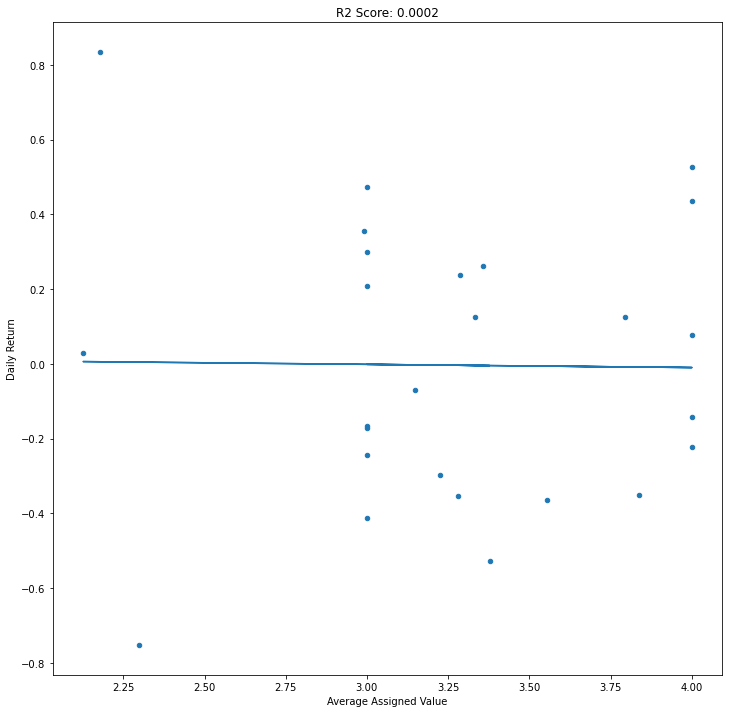

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.637492,0.123251,0.613196,-0.473507,-0.438624
Last Close,0.637492,1.000000,0.050735,0.623580,0.347639,0.393024
Date,0.123251,0.050735,1.000000,0.011475,-0.038019,-0.037363
Average Assigned Value,0.613196,0.623580,0.011475,1.000000,-0.066338,-0.012441
Total Return Fraction,-0.473507,0.347639,-0.038019,-0.066338,1.000000,0.993688
Daily Return,-0.438624,0.393024,-0.037363,-0.012441,0.993688,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: XOM
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Reduce', 'Sector Outperform', 'Sector Perform', 'Sector Underperform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


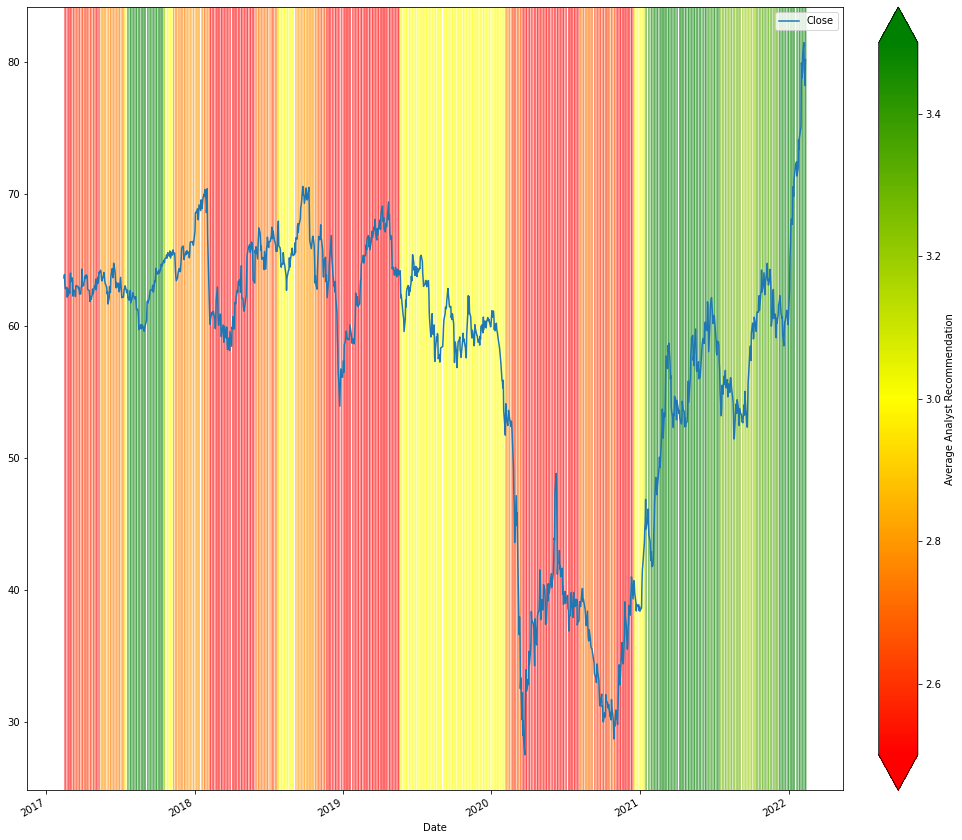

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998952,0.998880,0.997734,-0.588545,0.042086,-0.004737
High,0.998952,1.000000,0.998532,0.998943,-0.573445,0.045298,0.018547
Low,0.998880,0.998532,1.000000,0.998938,-0.603778,0.043938,0.019505
Close,0.997734,0.998943,0.998938,1.000000,-0.587680,0.045071,0.044393
Volume,-0.588545,-0.573445,-0.603778,-0.587680,1.000000,0.128432,0.016112
Average Assigned Value,0.042086,0.045298,0.043938,0.045071,0.128432,1.000000,0.027161
Returns,-0.004737,0.018547,0.019505,0.044393,0.016112,0.027161,1.000000


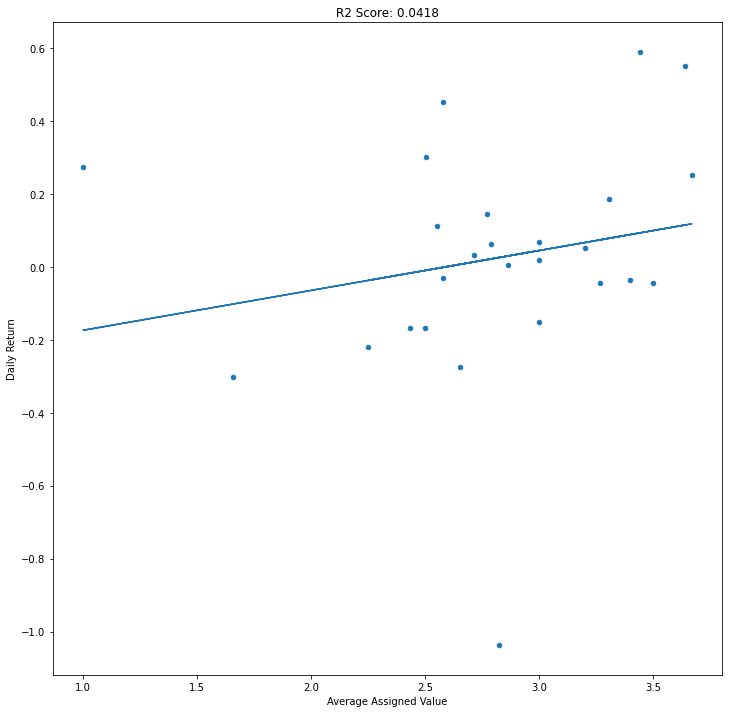

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.744494,-0.103613,-0.078861,-0.359914,-0.326269
Last Close,0.744494,1.000000,-0.042415,0.092723,0.340597,0.374582
Date,-0.103613,-0.042415,1.000000,0.234065,0.016353,0.034733
Average Assigned Value,-0.078861,0.092723,0.234065,1.000000,0.220229,0.204379
Total Return Fraction,-0.359914,0.340597,0.016353,0.220229,1.000000,0.989900
Daily Return,-0.326269,0.374582,0.034733,0.204379,0.989900,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: MO
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sector Perform', 'Sell', 'Underweight']


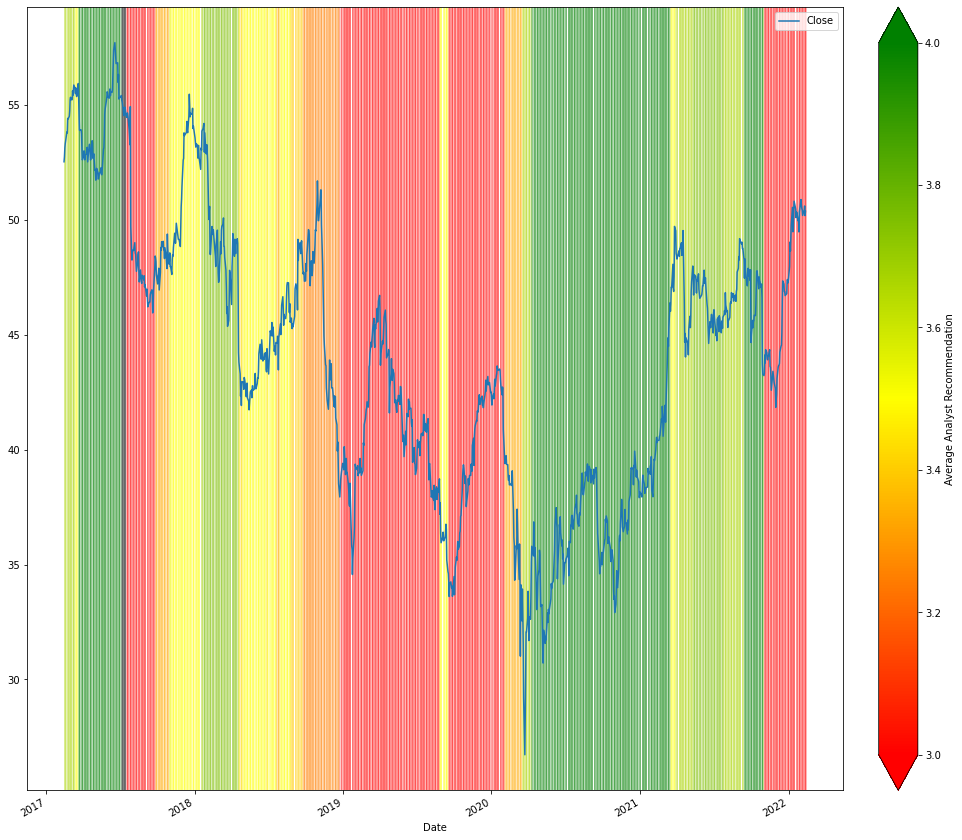

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998003,0.996368,0.995274,-0.291307,0.059260,-0.033269
High,0.998003,1.000000,0.995688,0.997371,-0.279366,0.059884,-0.001528
Low,0.996368,0.995688,1.000000,0.997853,-0.336177,0.061646,0.020745
Close,0.995274,0.997371,0.997853,1.000000,-0.313569,0.057298,0.046150
Volume,-0.291307,-0.279366,-0.336177,-0.313569,1.000000,-0.129000,-0.224830
Average Assigned Value,0.059260,0.059884,0.061646,0.057298,-0.129000,1.000000,0.001439
Returns,-0.033269,-0.001528,0.020745,0.046150,-0.224830,0.001439,1.000000


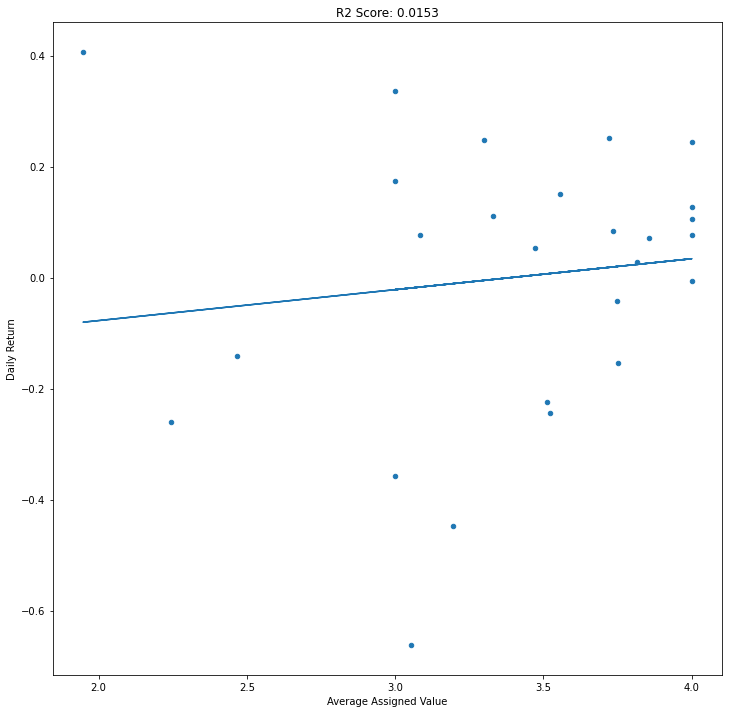

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.646844,-0.130944,0.000221,-0.477544,-0.472823
Last Close,0.646844,1.000000,0.057148,0.100380,0.355401,0.361920
Date,-0.130944,0.057148,1.000000,0.056768,0.211181,0.230397
Average Assigned Value,0.000221,0.100380,0.056768,1.000000,0.090722,0.123824
Total Return Fraction,-0.477544,0.355401,0.211181,0.090722,1.000000,0.995871
Daily Return,-0.472823,0.361920,0.230397,0.123824,0.995871,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: CMCSA
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Outperform', 'Sector Perform', 'Sector Weight', 'Strong Buy', 'Underweight']


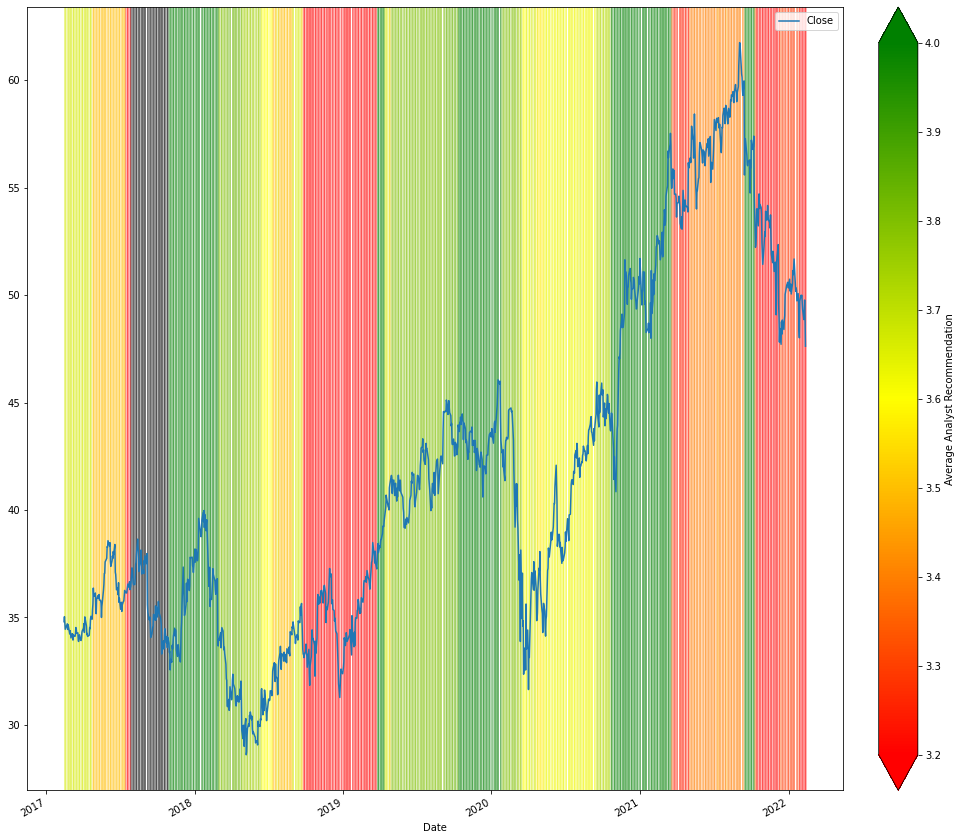

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998553,0.998544,0.997299,-0.279714,0.102599,-0.019414
High,0.998553,1.000000,0.997892,0.998567,-0.263298,0.103648,0.005007
Low,0.998544,0.997892,1.000000,0.998761,-0.300381,0.103418,0.011390
Close,0.997299,0.998567,0.998761,1.000000,-0.284293,0.104190,0.038476
Volume,-0.279714,-0.263298,-0.300381,-0.284293,1.000000,-0.024674,-0.100476
Average Assigned Value,0.102599,0.103648,0.103418,0.104190,-0.024674,1.000000,0.005625
Returns,-0.019414,0.005007,0.011390,0.038476,-0.100476,0.005625,1.000000


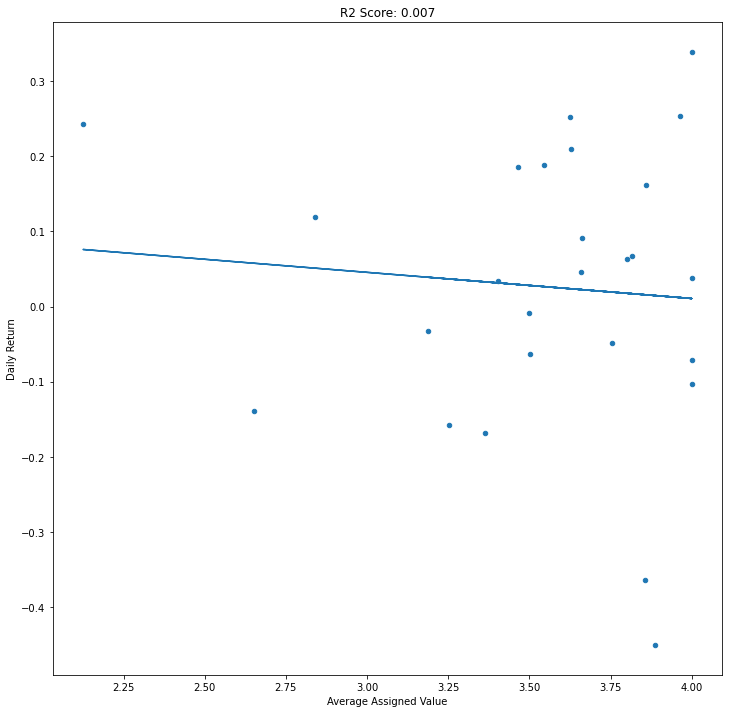

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.900780,-0.059999,0.098302,-0.266583,-0.255368
Last Close,0.900780,1.000000,-0.023630,0.076420,0.173581,0.184277
Date,-0.059999,-0.023630,1.000000,-0.034646,0.076986,0.080432
Average Assigned Value,0.098302,0.076420,-0.034646,1.000000,-0.080575,-0.083555
Total Return Fraction,-0.266583,0.173581,0.076986,-0.080575,1.000000,0.998328
Daily Return,-0.255368,0.184277,0.080432,-0.083555,0.998328,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: T
Recommendation values: ['Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Sector Perform', 'Sector Underperform', 'Sector Weight', 'Sell', 'Underperform', 'Underweight']


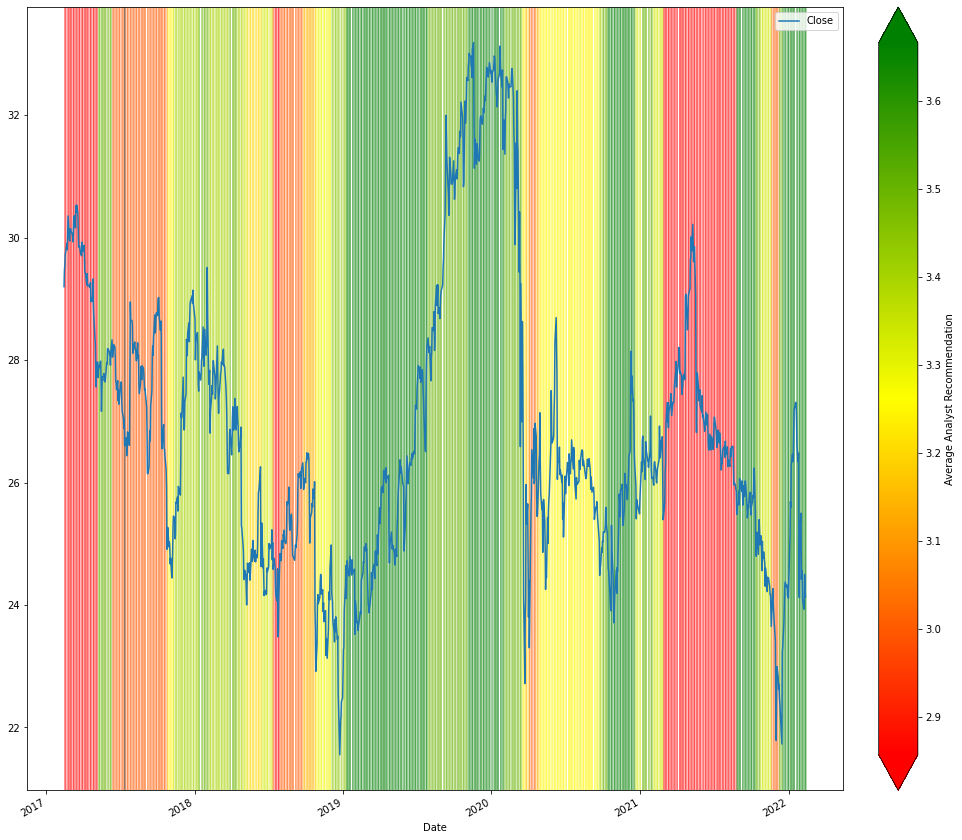

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.995174,0.994869,0.990805,-0.246466,-0.120434,-0.021778
High,0.995174,1.000000,0.992386,0.994805,-0.217889,-0.114547,0.022337
Low,0.994869,0.992386,1.000000,0.995498,-0.292709,-0.121042,0.038074
Close,0.990805,0.994805,0.995498,1.000000,-0.262863,-0.114020,0.086506
Volume,-0.246466,-0.217889,-0.292709,-0.262863,1.000000,0.039290,-0.178128
Average Assigned Value,-0.120434,-0.114547,-0.121042,-0.114020,0.039290,1.000000,0.030973
Returns,-0.021778,0.022337,0.038074,0.086506,-0.178128,0.030973,1.000000


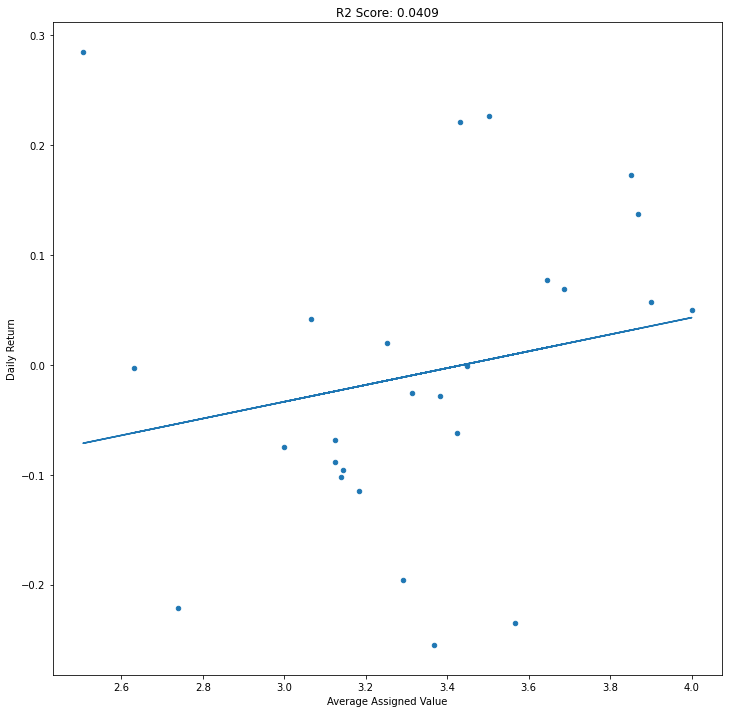

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.658393,-0.114536,-0.251281,-0.364562,-0.376991
Last Close,0.658393,1.000000,-0.197679,-0.092742,0.458107,0.446407
Date,-0.114536,-0.197679,1.000000,-0.253427,-0.118256,-0.126008
Average Assigned Value,-0.251281,-0.092742,-0.253427,1.000000,0.191422,0.202189
Total Return Fraction,-0.364562,0.458107,-0.118256,0.191422,1.000000,0.998980
Daily Return,-0.376991,0.446407,-0.126008,0.202189,0.998980,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: BA
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'In-Line', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Perform', 'Sell', 'Underperform', 'Underweight']


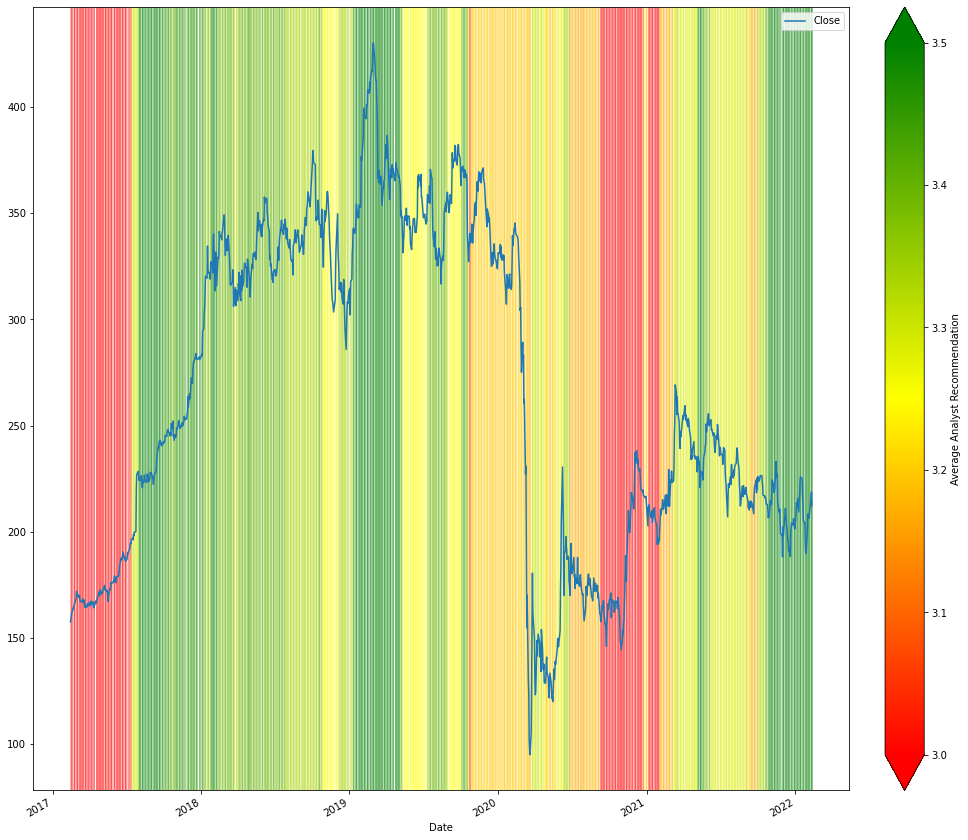

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999058,0.998798,0.997926,-0.472268,0.379307,-0.024499
High,0.999058,1.000000,0.998258,0.998832,-0.457294,0.382046,-0.006321
Low,0.998798,0.998258,1.000000,0.998940,-0.488804,0.376148,-0.002603
Close,0.997926,0.998832,0.998940,1.000000,-0.473183,0.379603,0.018994
Volume,-0.472268,-0.457294,-0.488804,-0.473183,1.000000,-0.084142,0.084899
Average Assigned Value,0.379307,0.382046,0.376148,0.379603,-0.084142,1.000000,-0.009283
Returns,-0.024499,-0.006321,-0.002603,0.018994,0.084899,-0.009283,1.000000


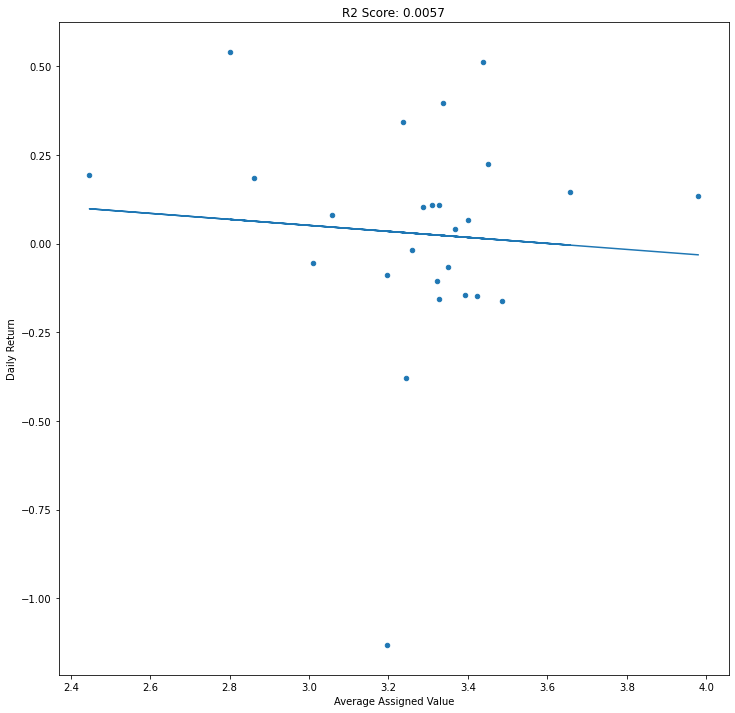

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.878562,-0.257206,0.378068,-0.407638,-0.379129
Last Close,0.878562,1.000000,-0.213013,0.393068,0.060231,0.100582
Date,-0.257206,-0.213013,1.000000,0.094219,0.118126,0.116167
Average Assigned Value,0.378068,0.393068,0.094219,1.000000,-0.106990,-0.075547
Total Return Fraction,-0.407638,0.060231,0.118126,-0.106990,1.000000,0.988751
Daily Return,-0.379129,0.100582,0.116167,-0.075547,0.988751,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: WFC
Recommendation values: ['Buy', 'Equal-Weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Positive', 'Sector Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


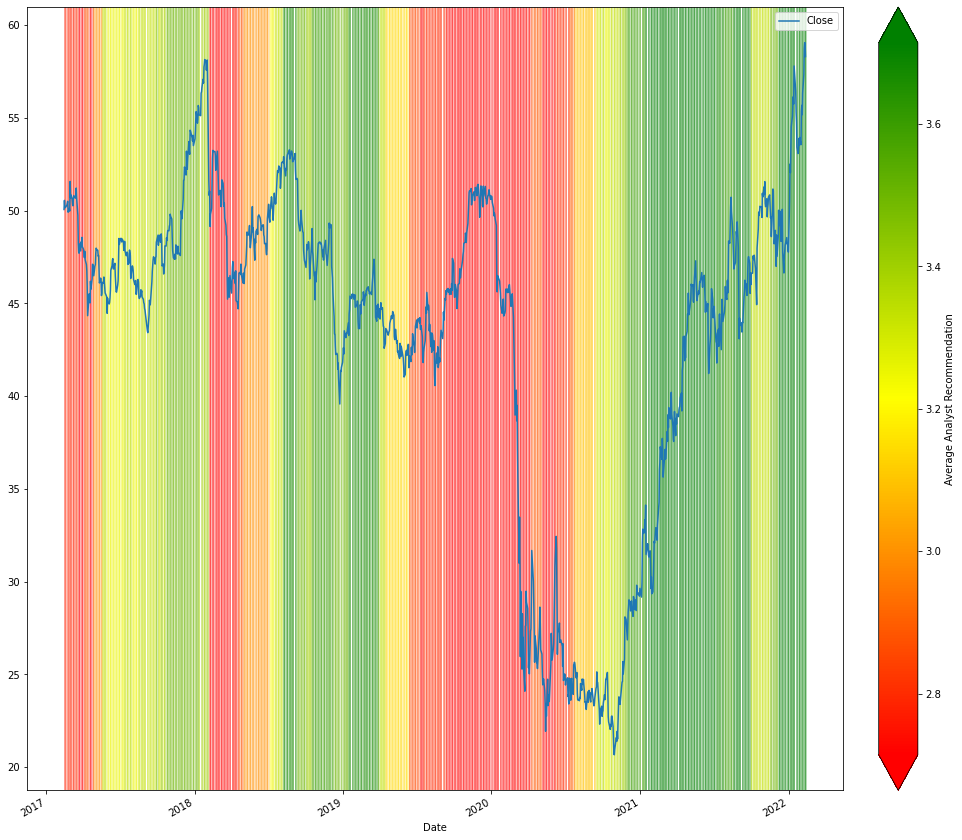

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998973,0.998788,0.997709,-0.572878,0.081380,-0.010945
High,0.998973,1.000000,0.998464,0.998879,-0.561080,0.086213,0.012116
Low,0.998788,0.998464,1.000000,0.998888,-0.588989,0.081708,0.012027
Close,0.997709,0.998879,0.998888,1.000000,-0.577002,0.085885,0.038767
Volume,-0.572878,-0.561080,-0.588989,-0.577002,1.000000,0.011470,-0.043118
Average Assigned Value,0.081380,0.086213,0.081708,0.085885,0.011470,1.000000,0.065881
Returns,-0.010945,0.012116,0.012027,0.038767,-0.043118,0.065881,1.000000


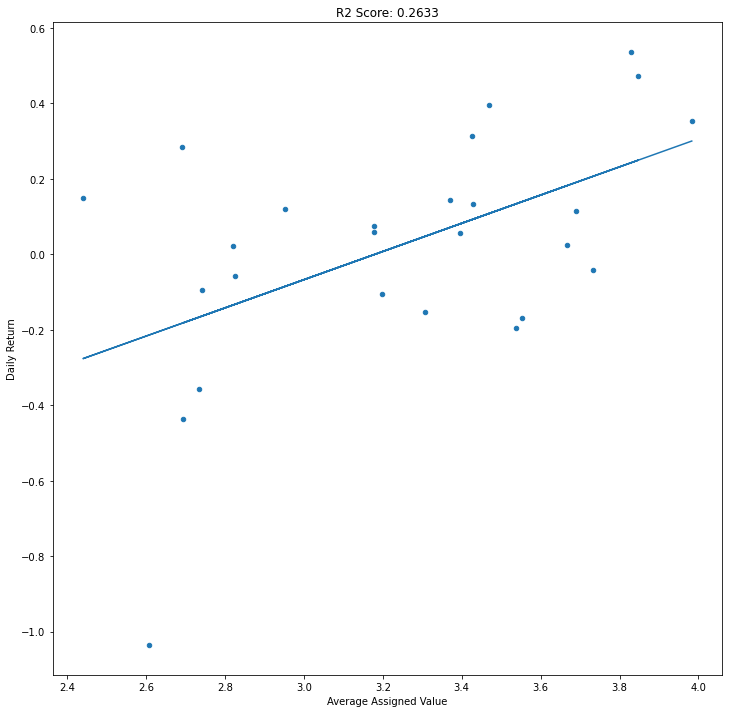

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.769361,-0.066126,-0.035416,-0.345641,-0.336734
Last Close,0.769361,1.000000,-0.107536,0.298085,0.318009,0.331594
Date,-0.066126,-0.107536,1.000000,-0.075192,-0.110045,-0.085928
Average Assigned Value,-0.035416,0.298085,-0.075192,1.000000,0.522651,0.513161
Total Return Fraction,-0.345641,0.318009,-0.110045,0.522651,1.000000,0.991925
Daily Return,-0.336734,0.331594,-0.085928,0.513161,0.991925,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: JPM
Recommendation values: ['Buy', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


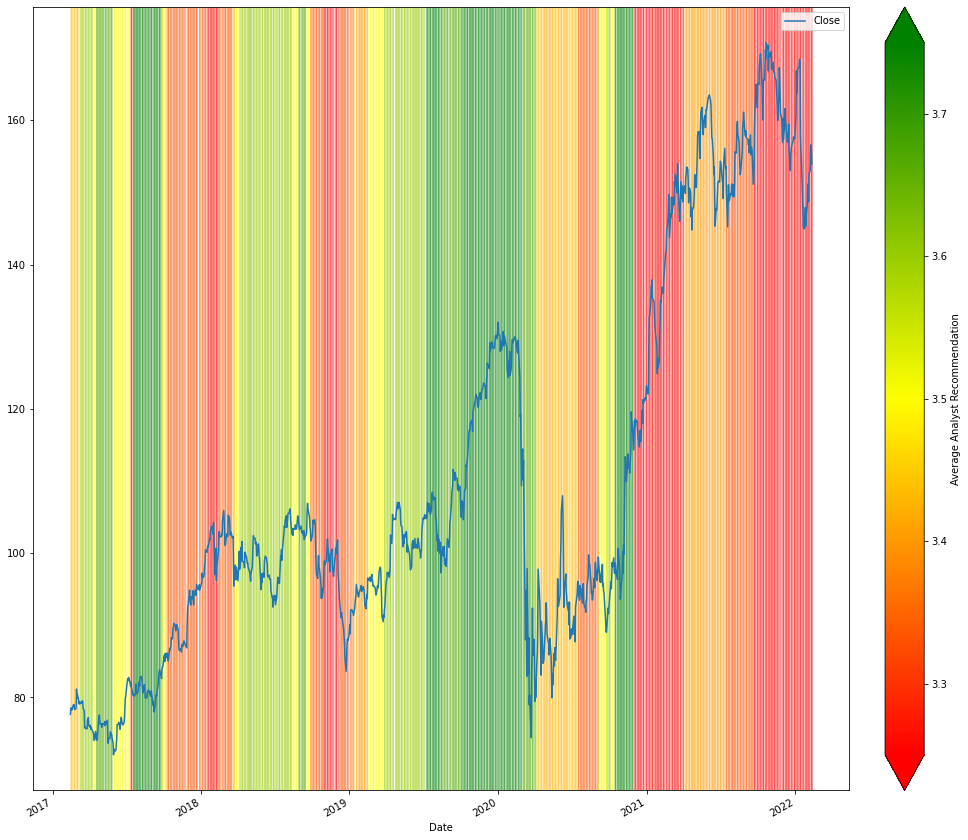

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999301,0.999235,0.998623,-0.204427,-0.427713,-0.001395
High,0.999301,1.000000,0.998855,0.999283,-0.190574,-0.429533,0.015142
Low,0.999235,0.998855,1.000000,0.999275,-0.225033,-0.422790,0.015181
Close,0.998623,0.999283,0.999275,1.000000,-0.210065,-0.424983,0.034788
Volume,-0.204427,-0.190574,-0.225033,-0.210065,1.000000,-0.077336,-0.069308
Average Assigned Value,-0.427713,-0.429533,-0.422790,-0.424983,-0.077336,1.000000,0.004420
Returns,-0.001395,0.015142,0.015181,0.034788,-0.069308,0.004420,1.000000


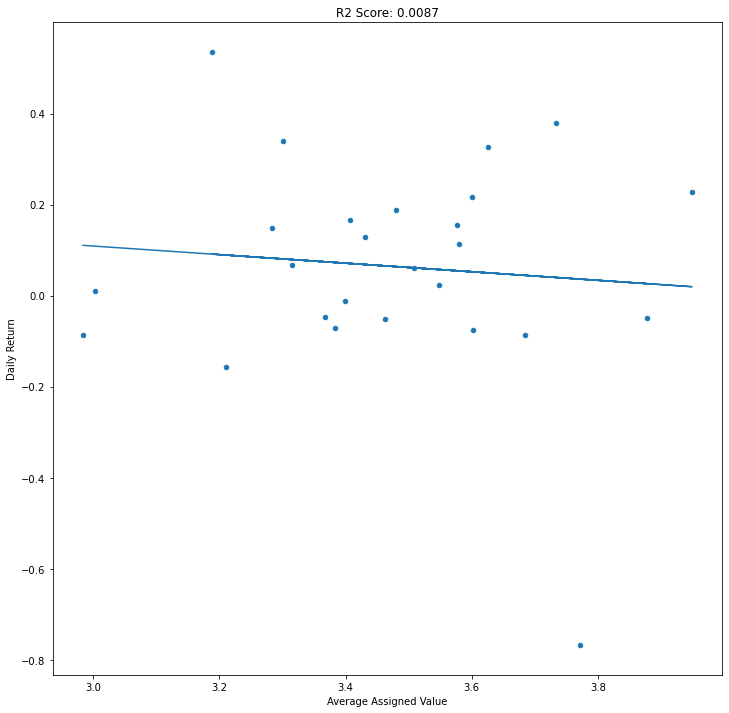

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.889007,-0.001013,-0.487604,-0.228382,-0.230990
Last Close,0.889007,1.000000,-0.080432,-0.520478,0.238067,0.237305
Date,-0.001013,-0.080432,1.000000,0.117105,-0.174378,-0.147963
Average Assigned Value,-0.487604,-0.520478,0.117105,1.000000,-0.067237,-0.093150
Total Return Fraction,-0.228382,0.238067,-0.174378,-0.067237,1.000000,0.994395
Daily Return,-0.230990,0.237305,-0.147963,-0.093150,0.994395,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: TSLA
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Hold', 'In-Line', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Peer Perform', 'Perform', 'Sector Perform', 'Sector Weight', 'Sell', 'Underperform', 'Underperformer', 'Underweight']


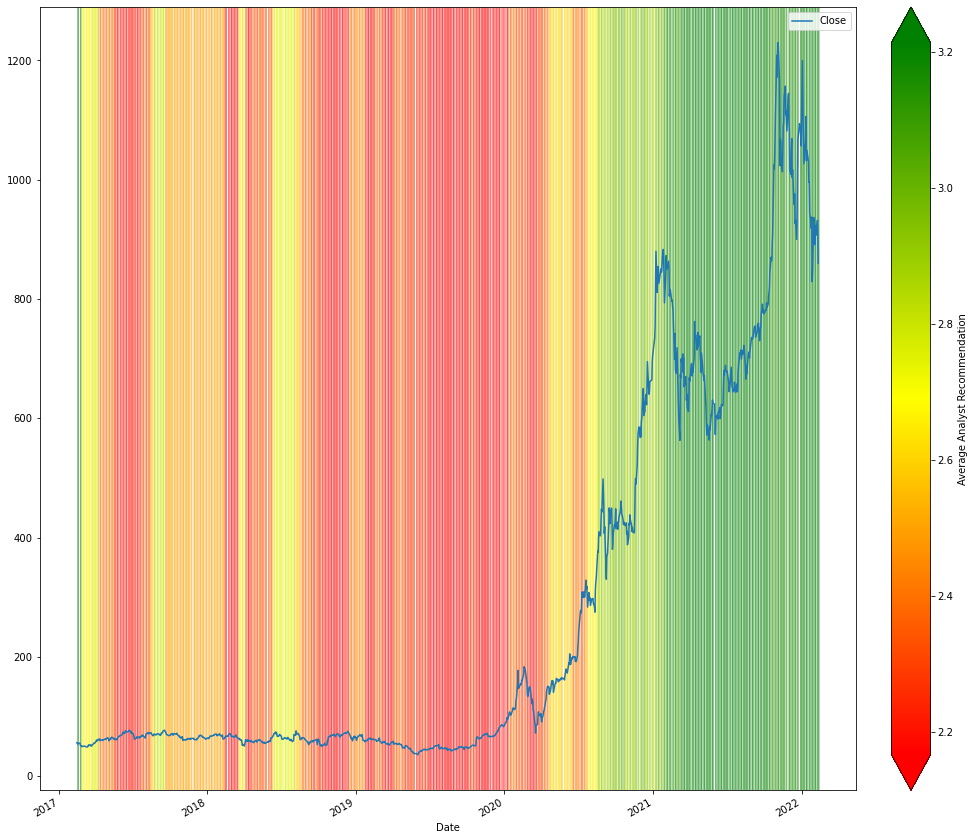

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.999668,0.999480,0.999048,-0.205210,0.828372,-0.000648
High,0.999668,1.000000,0.999452,0.999555,-0.198973,0.827163,0.010020
Low,0.999480,0.999452,1.000000,0.999578,-0.211798,0.830030,0.010868
Close,0.999048,0.999555,0.999578,1.000000,-0.204053,0.828368,0.022728
Volume,-0.205210,-0.198973,-0.211798,-0.204053,1.000000,-0.245110,0.114044
Average Assigned Value,0.828372,0.827163,0.830030,0.828368,-0.245110,1.000000,-0.017372
Returns,-0.000648,0.010020,0.010868,0.022728,0.114044,-0.017372,1.000000


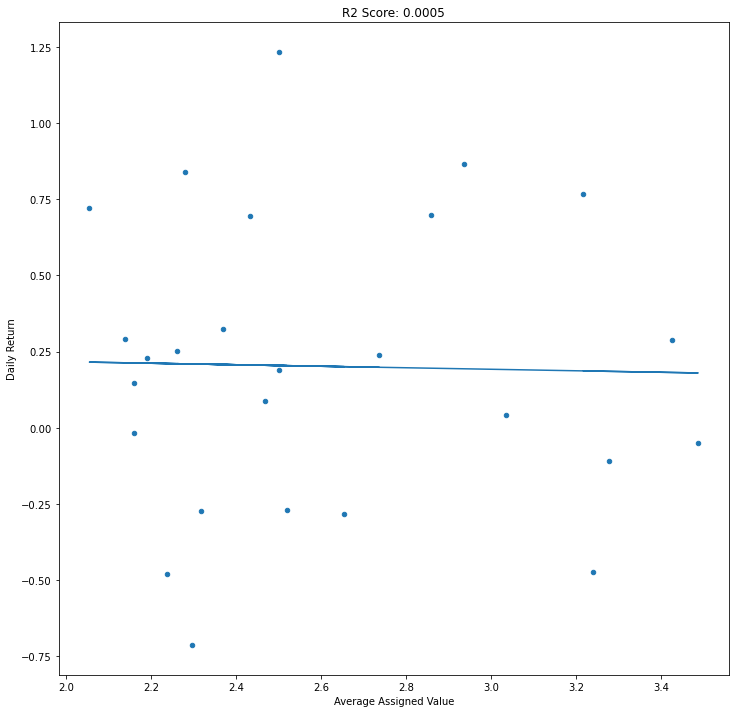

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.951233,0.045400,0.886891,-0.048386,-0.057353
Last Close,0.951233,1.000000,0.081299,0.884747,0.169847,0.159115
Date,0.045400,0.081299,1.000000,0.142684,0.118232,0.099808
Average Assigned Value,0.886891,0.884747,0.142684,1.000000,-0.023470,-0.022690
Total Return Fraction,-0.048386,0.169847,0.118232,-0.023470,1.000000,0.990493
Daily Return,-0.057353,0.159115,0.099808,-0.022690,0.990493,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: JNJ
Recommendation values: ['', 'Buy', 'Equal-Weight', 'Equal-weight', 'Hold', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Sell', 'Underperform', 'Underweight']


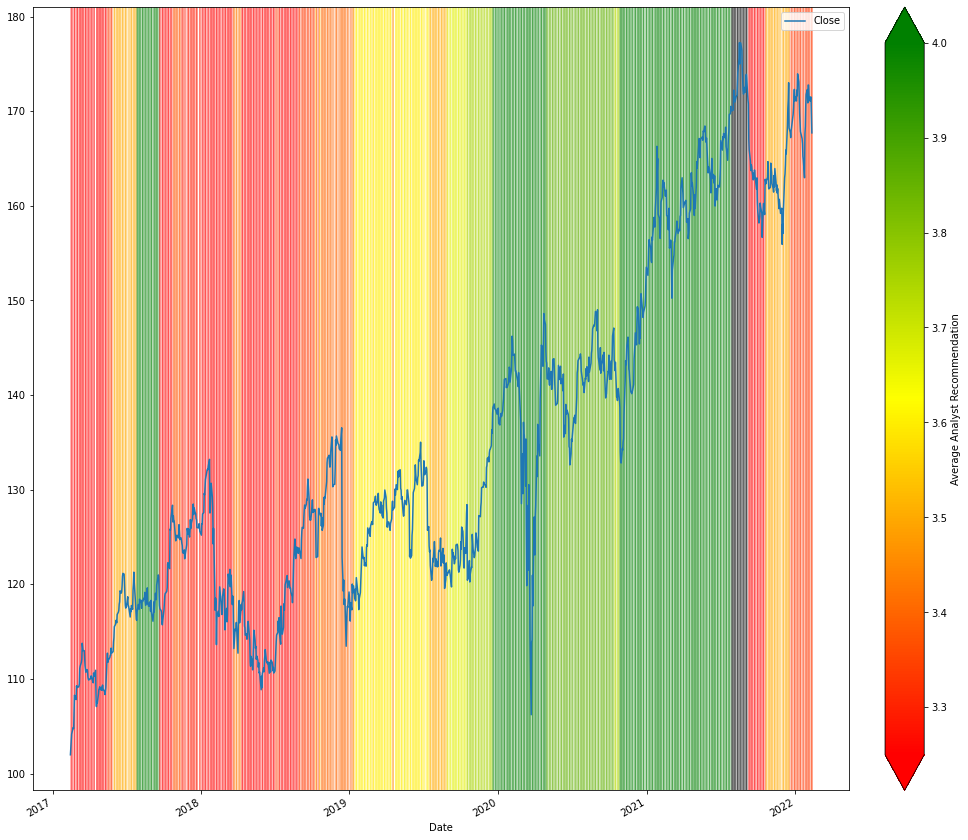

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.998692,0.998156,0.997259,0.013963,0.434279,-0.021543
High,0.998692,1.000000,0.997562,0.998488,0.031669,0.440493,0.001417
Low,0.998156,0.997562,1.000000,0.998608,-0.017844,0.428565,0.014383
Close,0.997259,0.998488,0.998608,1.000000,0.002123,0.435779,0.038246
Volume,0.013963,0.031669,-0.017844,0.002123,1.000000,0.115198,-0.189301
Average Assigned Value,0.434279,0.440493,0.428565,0.435779,0.115198,1.000000,0.028225
Returns,-0.021543,0.001417,0.014383,0.038246,-0.189301,0.028225,1.000000


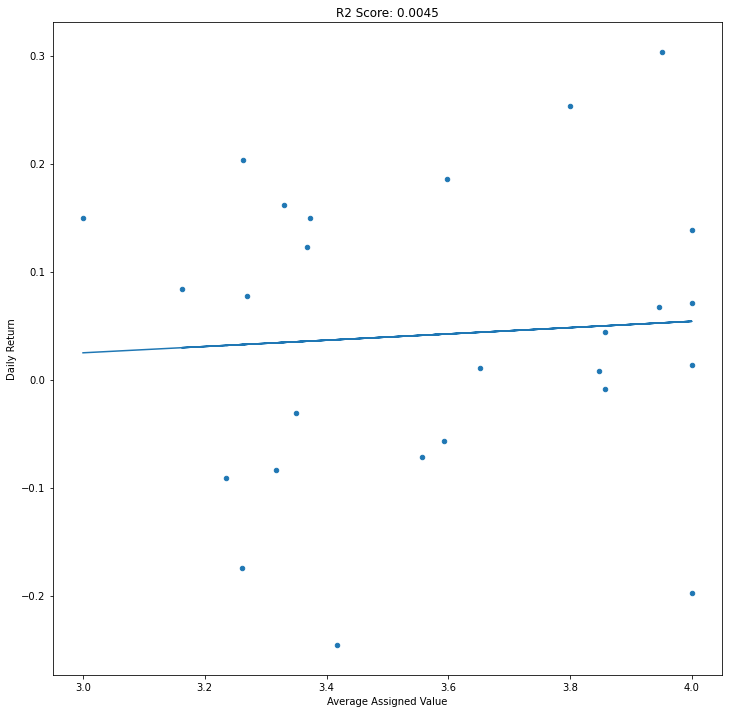

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.894097,-0.037286,0.410648,-0.295203,-0.280717
Last Close,0.894097,1.000000,0.018616,0.462533,0.161972,0.176913
Date,-0.037286,0.018616,1.000000,-0.144254,0.130367,0.134706
Average Assigned Value,0.410648,0.462533,-0.144254,1.000000,0.062881,0.066865
Total Return Fraction,-0.295203,0.161972,0.130367,0.062881,1.000000,0.998580
Daily Return,-0.280717,0.176913,0.134706,0.066865,0.998580,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Results for: BIIB
Recommendation values: ['Buy', 'Conviction Buy', 'Equal-Weight', 'Hold', 'Market Outperform', 'Market Perform', 'Neutral', 'Outperform', 'Overweight', 'Perform', 'Sector Perform', 'Sell', 'Strong Buy', 'Underperform', 'Underweight']


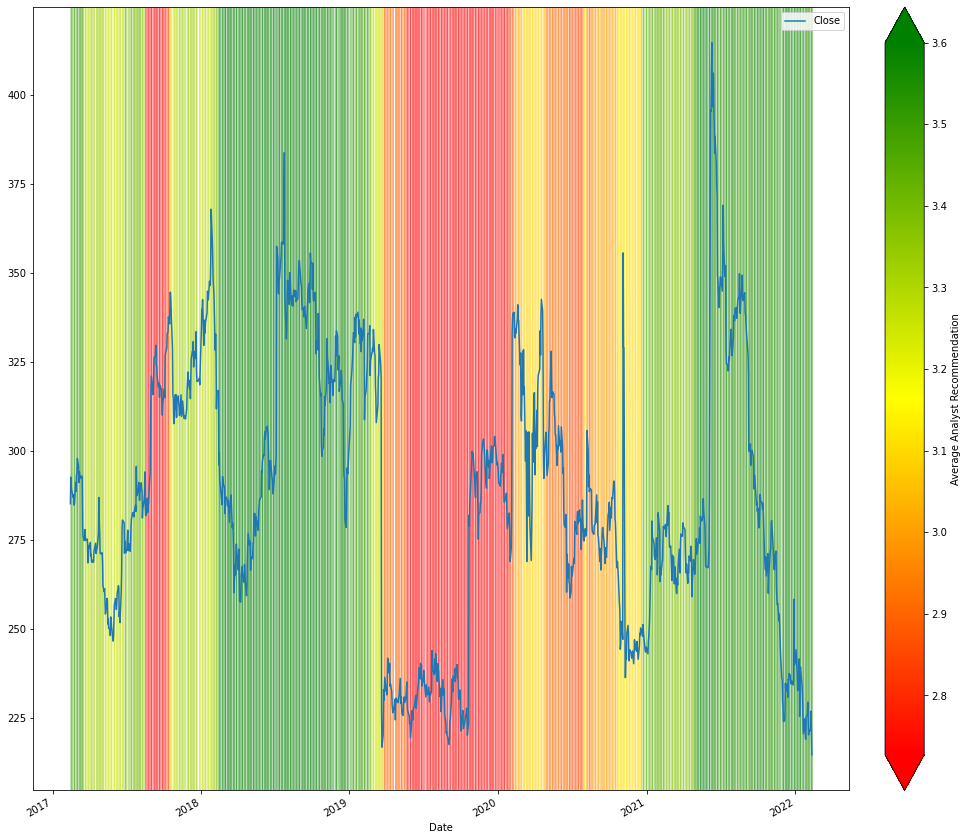

Correlation matrix for all data:


,Open,High,Low,Close,Volume,Average Assigned Value,Returns
Open,1.000000,0.983003,0.995515,0.985279,-0.046510,0.340920,-0.003676
High,0.983003,1.000000,0.980739,0.994283,0.048663,0.339592,0.117278
Low,0.995515,0.980739,1.000000,0.989582,-0.077915,0.341593,0.026331
Close,0.985279,0.994283,0.989582,1.000000,-0.002990,0.342936,0.123392
Volume,-0.046510,0.048663,-0.077915,-0.002990,1.000000,-0.084067,0.221446
Average Assigned Value,0.340920,0.339592,0.341593,0.342936,-0.084067,1.000000,-0.022649
Returns,-0.003676,0.117278,0.026331,0.123392,0.221446,-0.022649,1.000000


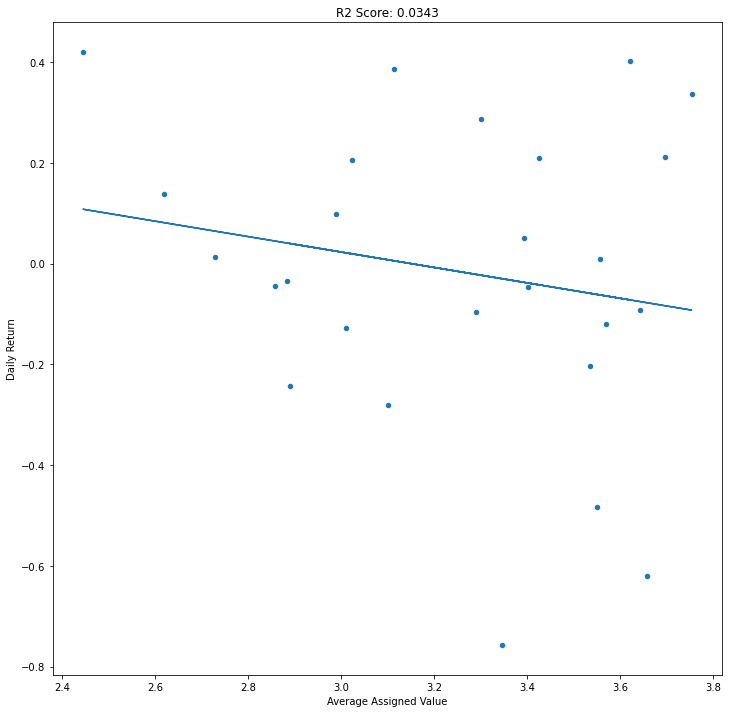

Correlation matrix for processed returns data:


,First Open,Last Close,Date,Average Assigned Value,Total Return Fraction,Daily Return
First Open,1.000000,0.389567,-0.028151,0.400466,-0.495519,-0.503768
Last Close,0.389567,1.000000,-0.169608,0.197721,0.599897,0.596378
Date,-0.028151,-0.169608,1.000000,-0.039221,-0.134133,-0.131371
Average Assigned Value,0.400466,0.197721,-0.039221,1.000000,-0.176114,-0.185307
Total Return Fraction,-0.495519,0.599897,-0.134133,-0.176114,1.000000,0.995393
Daily Return,-0.503768,0.596378,-0.131371,-0.185307,0.995393,1.000000


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [4]:
for i in stock_tickers:
    process_individual_stock(i)
#     process_individual_stock(i,returns_method='Recommendation Moves')